<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/S3_Captum_Optuna_VAE_3_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation 
---

In [1]:
# !pip install captum
# !pip install umap-learn
# !pip install datashader
# !pip install bokeh
# !pip install holoviews
!pip install tensorboardX
!pip install optuna
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
VAE Experiment 1 **[]** 2/27
---

In [3]:
import torch   
import torch.nn as nn                          
import torch.nn.functional as F                
import torch.optim as optim   
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd 
import numpy as np
import os                             

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns    

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

import torchvision
from torchvision import datasets

#based on sensor data can you determine the stimulus that is currently in use?
import optuna
from optuna.pruners import ThresholdPruner
from optuna import TrialPruned

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [4]:
df = pd.read_csv("/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/Subject_Experiment_1/S3_E1_A1.csv")
#drops all 0 labels (no label)
indices_to_drop = df[df["stimulus"] == 0].index
df.drop(indices_to_drop, inplace=True)

#Removes number of features from data
# df.drop('Cyber Glove (angles of the joints) Sensor 1', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 2', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 3', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 4', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 5', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 6', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 7', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 8', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 9', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 10', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 11', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 12', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 13', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 14', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 15', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 16', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 17', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 18', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 19', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 20', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 21', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 22', inplace=True, axis=1)

In [5]:
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
864,1,-0.092773,0.65088,-0.72656,1,11,2,-2,-5,-6,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
865,1,-0.092773,0.65088,-0.72656,-10,8,2,4,22,11,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
866,1,-0.092773,0.65088,-0.72656,8,2,1,-2,-6,-1,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
867,1,-0.086914,0.66162,-0.73145,-10,14,1,2,-11,-10,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
868,1,-0.086914,0.66162,-0.73145,12,-15,-2,-2,14,5,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941


In [6]:
X = df.drop('stimulus', axis=1)
#y = df['stimulus']
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()

(80618, 41) <class 'pandas.core.frame.DataFrame'> (80618, 1) <class 'pandas.core.frame.DataFrame'>



In [7]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
864,-0.092773,0.65088,-0.72656,1,11,2,-2,-5,-6,11,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
865,-0.092773,0.65088,-0.72656,-10,8,2,4,22,11,0,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
866,-0.092773,0.65088,-0.72656,8,2,1,-2,-6,-1,8,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
867,-0.086914,0.66162,-0.73145,-10,14,1,2,-11,-10,3,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941
868,-0.086914,0.66162,-0.73145,12,-15,-2,-2,14,5,-11,...,12.058,-27.773,6.3106,23.424,24.263,2.1741,16.398,64.597,-4.5882,1.6941


---
Visualization number of labels

stimulus
12          6796
5           6794
11          6784
6           6774
8           6772
7           6768
1           6719
10          6685
2           6656
4           6638
3           6620
9           6612
dtype: int64

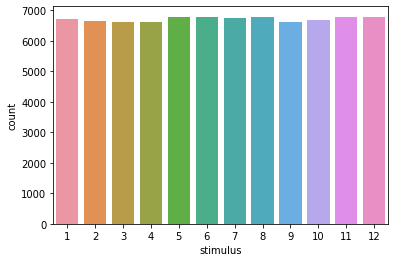

In [8]:
sns.countplot(x = 'stimulus', data=df)
y.value_counts()

---
Fixing Data Imbalance via Undersampling

<Axes: xlabel='stimulus'>

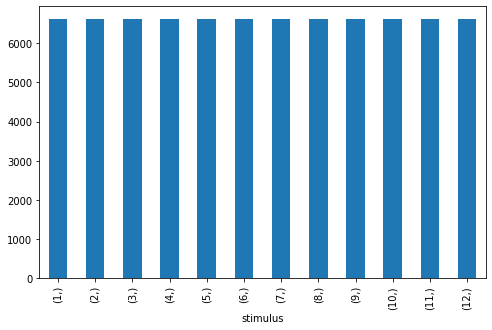

In [9]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = "not minority"
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts().plot(kind='bar', figsize=(8,5))

In [10]:
print(y_res.value_counts())
print(len(X_res.value_counts()))

stimulus
1           6612
2           6612
3           6612
4           6612
5           6612
6           6612
7           6612
8           6612
9           6612
10          6612
11          6612
12          6612
dtype: int64
79344


In [11]:
print(y)

        stimulus
864            1
865            1
866            1
867            1
868            1
...          ...
131361        12
131362        12
131363        12
131364        12
131365        12

[80618 rows x 1 columns]


---
Visualization of Data Distributions

In [12]:
# #distribution of first 19 features


# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(40, 40))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 20:
#     break 
# plt.tight_layout()

---
Defining Hyperparmaeters

In [13]:
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

#Hyperparameters
emg_channels = 16
imu_channels = 3

latent_dim = 2
input_dim= len(X.columns)

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
output_dim = len(X.columns)
num_classes = 12
num_layers = round(num_classes/2)
tempature = 1

num_epochs= 10
batch_size= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0


alpha = 2        # Reconstruction Loss
beta = 2         # Kl Divergence Loss
gamma = 3        # Classifcation Loss
delta = 5        # Contrastive Loss
epsilon = 3      # Triplet Loss

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train Test Split

In [14]:
X = X_res.values
y = y_res.values
print(X.shape, type(X), y.shape, type(y))
print()

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

(79344, 41) <class 'numpy.ndarray'> (79344, 1) <class 'numpy.ndarray'>

X_train size: 47606 | X_val size: 15869 | X_test size: 15869
y_train size: 47606 | y_val size: 15869 | y_test size: 15869

Training Feature Split: (47606, 41) | Training Labels (47606, 1)
Validation Feature Split: (15869, 41) | Validation Labels (15869, 1)
Testing Feature Split: (15869, 41) | Testing Labels (15869, 1)



---
Scaling/Normalizing Data

In [15]:
#Normalization Data 

#No Normalization 
# X_train_Normalized = X_train
# X_val_Normalized = X_val
# X_test_Normalized = X_test
#----------------------------------------------------------------------------------------------------------
# Minmax without preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train)
# X_val_Normalized = Minmax.transform(X_val)
# X_test_Normalized = Minmax.transform(X_test)
#----------------------------------------------------------------------------------------------------------
# Minmax with preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train_preprocessed)
# X_val_Normalized = Minmax.transform(X_val_preprocessed)
# X_test_Normalized = Minmax.transform(X_test_preprocessed)

#----------------------------------------------------------------------------------------------------------
# # Standardization without preprocessing
Standardized = preprocessing.StandardScaler()
X_train_Normalized= Standardized.fit_transform(X_train)
X_val_Normalized = Standardized.transform(X_val)
X_test_Normalized = Standardized.transform(X_test)

# Standardization with preprocessing
# Standardized = preprocessing.StandardScaler()
# X_train_Normalized= Standardized.fit_transform(X_train_preprocessed)
# X_val_Normalized = Standardized.transform(X_val_preprocessed)
# X_test_Normalized = Standardized.transform(X_test_preprocessed)
#----------------------------------------------------------------------------------------------------------

#Convert to numpy then to torch 

X_train = torch.from_numpy(X_train_Normalized).float()
y_train = torch.from_numpy(y_train).long()

X_val = torch.from_numpy(X_val_Normalized).float()
y_val = torch.from_numpy(y_val).long()

X_test = torch.from_numpy(X_test_Normalized).float()
y_test = torch.from_numpy(y_test).long()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , { y_train.shape}")
print(f"Validation: {X_val.shape} , { y_val.shape}")
print(f"Testing:  {X_test.shape} , { y_test.shape}")

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([47606, 41]) , torch.Size([47606, 1])
Validation: torch.Size([15869, 41]) , torch.Size([15869, 1])
Testing:  torch.Size([15869, 41]) , torch.Size([15869, 1])


---
Defining Dataloaders


In [16]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [17]:
training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

def get_data_loader(optuna_batch_size):
  train_loader = DataLoader(training, batch_size=optuna_batch_size, shuffle=True)
  val_loader = DataLoader(validating, batch_size=optuna_batch_size, shuffle=False)
  test_loader = DataLoader(testing, batch_size=optuna_batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

---
Defining VAE Model, Loss and Optmizers

In [18]:
class VAE(nn.Module):  
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()  
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.ReLU(),
        nn.Linear(num_layers, 13),
        nn.Softmax(dim=1)
    )

  def encode(self, x):  
    z = self.encoder(x)
    z1 = self.mu(z)               
    z2 = self.logvar(z) 
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)   

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)
    classified = classified / tempature

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")
  
  print(f"Logvar: {logvar.shape}")
 
  print(f"Latent Space Z: {z_reparmeterized.shape}")
 
  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 13])


In [19]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss

In [20]:
def train_VAE(trial, model, train_loader, val_loader, optimizer, epoch,alpha,beta,gamma, delta):
  train_losses=[]
  train_accuracy = []
  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  recon_loss_fn = nn.MSELoss(reduction="sum")
  classifier_loss_fn = nn.CrossEntropyLoss()
  contrastive_loss_fn = ContrastiveLoss(margin=1)

  train_running_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = recon_loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

  
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + (delta*contrastive_loss)

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = recon_loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  trial.report(train_acc, epoch)
  if trial.should_prune():
      raise optuna.TrialPruned()

  return train_losses, val_losses, train_acc, val_acc



In [21]:
def objective(trial):
  params = {
          'optuna_batch_size' : trial.suggest_int('optuna_batch_size', 1e2, 1e3),
          'num_epochs' : num_epochs,
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
          "lr": trial.suggest_float('lr', 1e-4, 1e-2),
          "hidden_dim": trial.suggest_int('hidden_dim', 1e2, 1e3),
          'alpha': trial.suggest_int('alpha', 1e-1, 1e1),
          'beta': trial.suggest_int('beta', 1e-1, 1e1), 
          'gamma': trial.suggest_int('gamma', 1e-1, 1e1), 
          'delta': trial.suggest_int('delta', 1e-1, 1e1),        
  }

  train_loader, val_loader, test_loader = get_data_loader(params['optuna_batch_size'])
  model  = VAE(input_dim, params['hidden_dim'], latent_dim).to(device)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

  for epoch in range(params['num_epochs']):
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  return train_acc


In [22]:
sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=ThresholdPruner(lower=0.3, n_warmup_steps=3, interval_steps=1),
    direction='maximize')
study.optimize(func=objective, n_trials=200)

[I 2023-03-17 20:27:31,229] A new study created in memory with name: no-name-de7ee9dd-ae7b-40d8-893a-dd7d9c14d999


Epoch: 1 / 10 | Reconst_loss: 1271.252 | Kldiv loss: 371.737 | Classifcation loss: 2.423 | Constrast loss: 35.51 | Total loss: 18030.528 | Train acc: 24.016 % ||| Val Loss: 12558.344 | Val acc: 36.994 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1051.489 | Kldiv loss: 273.397 | Classifcation loss: 2.264 | Constrast loss: 7.61 | Total loss: 11427.540 | Train acc: 38.865 % ||| Val Loss: 10653.220 | Val acc: 46.262 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 10 | Reconst_loss: 1017.436 | Kldiv loss: 335.390 | Classifcation loss: 2.262 | Constrast loss: 3.53 | Total loss: 9988.822 | Train acc: 50.271 % ||| Val Loss: 9289.162 | Val acc: 54.171 %
-------------------------------

[I 2023-03-17 20:28:40,905] Trial 0 finished with value: 0.7072942972818343 and parameters: {'optuna_batch_size': 164, 'optimizer': 'RMSprop', 'lr': 0.0017748557272216148, 'hidden_dim': 457, 'alpha': 9, 'beta': 2, 'gamma': 6, 'delta': 4}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 948.550 | Kldiv loss: 247.292 | Classifcation loss: 1.896 | Constrast loss: 0.09 | Total loss: 8222.563 | Train acc: 70.729 % ||| Val Loss: 8148.980 | Val acc: 71.381 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11857.746 | Kldiv loss: 4839.194 | Classifcation loss: 2.465 | Constrast loss: 1138.73 | Total loss: 335326.179 | Train acc: 12.447 % ||| Val Loss: 92840.325 | Val acc: 23.751 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 10408.264 | Kldiv loss: 3788.139 | Classifcation loss: 2.322 | Constrast loss: 821.41 | Total loss: 80529.426 | Train acc: 30.886 % ||| Val Loss: 72038.059 | Val acc: 35.505 %
----------------------

[I 2023-03-17 20:28:57,035] Trial 1 finished with value: 0.6639781514823327 and parameters: {'optuna_batch_size': 695, 'optimizer': 'Adam', 'lr': 0.009918279791500482, 'hidden_dim': 109, 'alpha': 2, 'beta': 9, 'gamma': 0, 'delta': 2}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 7088.203 | Kldiv loss: 2561.912 | Classifcation loss: 2.013 | Constrast loss: 204.53 | Total loss: 41950.050 | Train acc: 66.398 % ||| Val Loss: 42151.931 | Val acc: 66.985 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3226.567 | Kldiv loss: 855.746 | Classifcation loss: 2.394 | Constrast loss: 142.52 | Total loss: 20050.249 | Train acc: 17.749 % ||| Val Loss: 13432.683 | Val acc: 25.007 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2608.542 | Kldiv loss: 876.106 | Classifcation loss: 2.299 | Constrast loss: 75.34 | Total loss: 11984.559 | Train acc: 37.542 % ||| Val Loss: 10786.987 | Val acc: 47.994 %
-----------------------

[I 2023-03-17 20:31:30,154] Trial 2 finished with value: 0.6125741946637469 and parameters: {'optuna_batch_size': 184, 'optimizer': 'Adam', 'lr': 0.00166612280657838, 'hidden_dim': 730, 'alpha': 9, 'beta': 4, 'gamma': 6, 'delta': 9}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 2778.928 | Kldiv loss: 764.471 | Classifcation loss: 2.037 | Constrast loss: 5.17 | Total loss: 9078.504 | Train acc: 61.257 % ||| Val Loss: 9059.570 | Val acc: 61.142 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 20528.400 | Kldiv loss: 13212.427 | Classifcation loss: 2.476 | Constrast loss: 4757.09 | Total loss: 479718.650 | Train acc: 13.467 % ||| Val Loss: 100187.562 | Val acc: 15.726 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 16298.924 | Kldiv loss: 9858.504 | Classifcation loss: 2.459 | Constrast loss: 3425.46 | Total loss: 90755.280 | Train acc: 18.139 % ||| Val Loss: 79591.474 | Val acc: 22.154 %
------------------

[I 2023-03-17 20:32:49,796] Trial 3 finished with value: 0.6924325264153836 and parameters: {'optuna_batch_size': 653, 'optimizer': 'Adam', 'lr': 0.004888530264755015, 'hidden_dim': 674, 'alpha': 9, 'beta': 5, 'gamma': 6, 'delta': 9}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 10927.143 | Kldiv loss: 4984.016 | Classifcation loss: 2.036 | Constrast loss: 456.35 | Total loss: 39707.084 | Train acc: 69.243 % ||| Val Loss: 38983.234 | Val acc: 70.094 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 19137.590 | Kldiv loss: 11923.258 | Classifcation loss: 2.525 | Constrast loss: 4592.07 | Total loss: 2498712.104 | Train acc: 10.031 % ||| Val Loss: 142165.165 | Val acc: 12.619 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15778.299 | Kldiv loss: 10453.673 | Classifcation loss: 2.435 | Constrast loss: 2883.49 | Total loss: 125788.492 | Train acc: 19.286 % ||| Val Loss: 111146.779 | Val acc: 23.870 %
--------

[I 2023-03-17 20:34:49,925] Trial 4 finished with value: 0.5830094600108167 and parameters: {'optuna_batch_size': 871, 'optimizer': 'Adam', 'lr': 0.003939302253394884, 'hidden_dim': 879, 'alpha': 0, 'beta': 7, 'gamma': 9, 'delta': 3}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 11133.730 | Kldiv loss: 5678.415 | Classifcation loss: 2.140 | Constrast loss: 612.13 | Total loss: 61672.978 | Train acc: 58.301 % ||| Val Loss: 60046.096 | Val acc: 58.053 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6969.910 | Kldiv loss: 3313.826 | Classifcation loss: 2.529 | Constrast loss: 191.74 | Total loss: 438726.770 | Train acc: 11.789 % ||| Val Loss: 131119.809 | Val acc: 19.824 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4594.040 | Kldiv loss: 2501.001 | Classifcation loss: 2.418 | Constrast loss: 138.37 | Total loss: 109399.607 | Train acc: 25.635 % ||| Val Loss: 90672.583 | Val acc: 32.461 %
----------------

[I 2023-03-17 20:35:08,950] Trial 5 finished with value: 0.5447775587669084 and parameters: {'optuna_batch_size': 895, 'optimizer': 'RMSprop', 'lr': 0.001992837511743985, 'hidden_dim': 165, 'alpha': 2, 'beta': 1, 'gamma': 0, 'delta': 7}. Best is trial 0 with value: 0.7072942972818343.


Epoch: 10 / 10 | Reconst_loss: 6693.580 | Kldiv loss: 2482.689 | Classifcation loss: 2.343 | Constrast loss: 79.31 | Total loss: 62610.194 | Train acc: 54.478 % ||| Val Loss: 85830.388 | Val acc: 42.124 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3445.633 | Kldiv loss: 418.555 | Classifcation loss: 2.226 | Constrast loss: 64.74 | Total loss: 42739913.615 | Train acc: 29.887 % ||| Val Loss: 8923.156 | Val acc: 46.496 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2421.235 | Kldiv loss: 574.053 | Classifcation loss: 2.119 | Constrast loss: 19.27 | Total loss: 8217.213 | Train acc: 52.026 % ||| Val Loss: 7678.948 | Val acc: 55.325 %
-------------------------

[I 2023-03-17 20:36:33,984] Trial 6 finished with value: 0.8271228315161941 and parameters: {'optuna_batch_size': 110, 'optimizer': 'RMSprop', 'lr': 0.003086190887866044, 'hidden_dim': 465, 'alpha': 7, 'beta': 0, 'gamma': 9, 'delta': 7}. Best is trial 6 with value: 0.8271228315161941.


Epoch: 10 / 10 | Reconst_loss: 1490.141 | Kldiv loss: 377.488 | Classifcation loss: 1.949 | Constrast loss: 25.28 | Total loss: 5817.412 | Train acc: 82.712 % ||| Val Loss: 5573.581 | Val acc: 82.805 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2326.921 | Kldiv loss: 3418.385 | Classifcation loss: 2.572 | Constrast loss: 154.90 | Total loss: 835662.811 | Train acc: 7.062 % ||| Val Loss: 226400.429 | Val acc: 6.469 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2629.531 | Kldiv loss: 2921.355 | Classifcation loss: 2.545 | Constrast loss: 135.15 | Total loss: 224540.154 | Train acc: 8.641 % ||| Val Loss: 200963.430 | Val acc: 9.395 %
------------------------

[I 2023-03-17 20:36:44,119] Trial 7 pruned. 


Epoch: 4 / 10 | Reconst_loss: 1279.120 | Kldiv loss: 550.453 | Classifcation loss: 2.520 | Constrast loss: 57.42 | Total loss: 77344.944 | Train acc: 16.349 % ||| Val Loss: 71552.606 | Val acc: 16.266 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 22539.422 | Kldiv loss: 24577.109 | Classifcation loss: 2.502 | Constrast loss: 12160.99 | Total loss: 431426.196 | Train acc: 12.966 % ||| Val Loss: 234411.153 | Val acc: 18.431 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19004.316 | Kldiv loss: 7222.196 | Classifcation loss: 2.421 | Constrast loss: 1550.29 | Total loss: 132727.039 | Train acc: 22.281 % ||| Val Loss: 91998.596 | Val acc: 27.734 %
--------------

[I 2023-03-17 20:37:27,758] Trial 8 finished with value: 0.5506362734984527 and parameters: {'optuna_batch_size': 870, 'optimizer': 'Adam', 'lr': 0.009386606852657112, 'hidden_dim': 439, 'alpha': 9, 'beta': 5, 'gamma': 2, 'delta': 3}. Best is trial 6 with value: 0.8271228315161941.


Epoch: 10 / 10 | Reconst_loss: 13208.258 | Kldiv loss: 3749.301 | Classifcation loss: 2.101 | Constrast loss: 485.12 | Total loss: 54549.961 | Train acc: 55.064 % ||| Val Loss: 50232.814 | Val acc: 56.056 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.088 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-----------------------------------------------------------------------------

[I 2023-03-17 20:38:09,895] Trial 9 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11916.690 | Kldiv loss: 7850.390 | Classifcation loss: 2.440 | Constrast loss: 2066.75 | Total loss: 562957312241265410048.000 | Train acc: 18.826 % ||| Val Loss: 66405.595 | Val acc: 26.226 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9778.568 | Kldiv loss: 4234.189 | Classifcation loss: 2.361 | Constrast loss: 1812.37 | Total loss: 60962.553 | Train acc: 30.633 % ||| Val Loss: 53307.483 | Val acc: 35.349 %
-------------------------------

[I 2023-03-17 20:38:40,788] Trial 10 finished with value: 0.41358044097920865 and parameters: {'optuna_batch_size': 426, 'optimizer': 'RMSprop', 'lr': 0.007215091499997689, 'hidden_dim': 302, 'alpha': 6, 'beta': 0, 'gamma': 8, 'delta': 0}. Best is trial 6 with value: 0.8271228315161941.


Epoch: 10 / 10 | Reconst_loss: 11575.217 | Kldiv loss: 4903.637 | Classifcation loss: 2.311 | Constrast loss: 671.35 | Total loss: 42355.210 | Train acc: 41.358 % ||| Val Loss: 40934.586 | Val acc: 40.945 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3601.258 | Kldiv loss: 883.920 | Classifcation loss: 2.410 | Constrast loss: 209.09 | Total loss: 4571395.176 | Train acc: 23.448 % ||| Val Loss: 11193.790 | Val acc: 32.466 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2556.396 | Kldiv loss: 874.475 | Classifcation loss: 2.252 | Constrast loss: 202.25 | Total loss: 10614.051 | Train acc: 40.337 % ||| Val Loss: 10012.776 | Val acc: 48.509 %
-------------------

[I 2023-03-17 20:39:59,051] Trial 11 finished with value: 0.7187429340207119 and parameters: {'optuna_batch_size': 126, 'optimizer': 'RMSprop', 'lr': 0.0025040230489953696, 'hidden_dim': 491, 'alpha': 6, 'beta': 2, 'gamma': 4, 'delta': 5}. Best is trial 6 with value: 0.8271228315161941.


Epoch: 10 / 10 | Reconst_loss: 1629.961 | Kldiv loss: 533.608 | Classifcation loss: 1.959 | Constrast loss: 34.47 | Total loss: 7115.496 | Train acc: 71.874 % ||| Val Loss: 6721.917 | Val acc: 74.363 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 188.041 | Kldiv loss: 43.800 | Classifcation loss: 2.313 | Constrast loss: 0.00 | Total loss: 62557.919 | Train acc: 28.649 % ||| Val Loss: 8856.733 | Val acc: 43.639 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 296.333 | Kldiv loss: 50.831 | Classifcation loss: 2.114 | Constrast loss: 0.00 | Total loss: 8429.662 | Train acc: 50.370 % ||| Val Loss: 7644.462 | Val acc: 57.218 %
-------------------------------------

[I 2023-03-17 20:41:30,612] Trial 12 finished with value: 0.8922702883970481 and parameters: {'optuna_batch_size': 112, 'optimizer': 'RMSprop', 'lr': 0.0034734538092972187, 'hidden_dim': 536, 'alpha': 6, 'beta': 3, 'gamma': 4, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 252.898 | Kldiv loss: 47.234 | Classifcation loss: 1.693 | Constrast loss: 0.00 | Total loss: 5979.204 | Train acc: 89.227 % ||| Val Loss: 5683.150 | Val acc: 92.044 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.971 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------

[I 2023-03-17 20:42:02,868] Trial 13 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.155 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:42:16,245] Trial 14 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.116 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:43:27,960] Trial 15 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.019 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:44:12,147] Trial 16 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11886.306 | Kldiv loss: 4035.190 | Classifcation loss: 2.555 | Constrast loss: 1644.70 | Total loss: 67479.514 | Train acc: 7.537 % ||| Val Loss: 43595.552 | Val acc: 12.156 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 12129.369 | Kldiv loss: 3019.535 | Classifcation loss: 2.547 | Constrast loss: 1139.52 | Total loss: 40242.007 | Train acc: 13.633 % ||| Val Loss: 37436.172 | Val acc: 16.555 %
-----------------------------------------------

[I 2023-03-17 20:44:29,185] Trial 17 pruned. 


Epoch: 4 / 10 | Reconst_loss: 11501.279 | Kldiv loss: 3137.519 | Classifcation loss: 2.528 | Constrast loss: 581.95 | Total loss: 33171.842 | Train acc: 19.031 % ||| Val Loss: 32494.865 | Val acc: 17.398 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 16074.526 | Kldiv loss: 4316.752 | Classifcation loss: 2.445 | Constrast loss: 1705.56 | Total loss: 1467595.419 | Train acc: 18.043 % ||| Val Loss: 58868.146 | Val acc: 23.188 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 14277.999 | Kldiv loss: 4308.677 | Classifcation loss: 2.319 | Constrast loss: 1169.61 | Total loss: 56540.692 | Train acc: 32.081 % ||| Val Loss: 51349.312 | Val acc: 41.872 %
--------------

[I 2023-03-17 20:45:27,504] Trial 18 finished with value: 0.5937519161084012 and parameters: {'optuna_batch_size': 524, 'optimizer': 'RMSprop', 'lr': 0.003355184449314709, 'hidden_dim': 548, 'alpha': 7, 'beta': 4, 'gamma': 9, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 9367.851 | Kldiv loss: 3608.150 | Classifcation loss: 2.040 | Constrast loss: 128.29 | Total loss: 33392.084 | Train acc: 59.375 % ||| Val Loss: 30893.368 | Val acc: 61.116 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.088 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------

[I 2023-03-17 20:46:23,377] Trial 19 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14610.900 | Kldiv loss: 10594.127 | Classifcation loss: 2.511 | Constrast loss: 2355.78 | Total loss: 757889186.775 | Train acc: 12.740 % ||| Val Loss: 201675.239 | Val acc: 20.284 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13904.145 | Kldiv loss: 8428.605 | Classifcation loss: 2.408 | Constrast loss: 1413.34 | Total loss: 182388.880 | Train acc: 26.613 % ||| Val Loss: 155113.821 | Val acc: 32.472 %
--------------------------------------

[I 2023-03-17 20:46:58,139] Trial 20 finished with value: 0.49981333997013433 and parameters: {'optuna_batch_size': 984, 'optimizer': 'RMSprop', 'lr': 0.0055628532905989065, 'hidden_dim': 376, 'alpha': 10, 'beta': 2, 'gamma': 2, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 9813.889 | Kldiv loss: 4601.973 | Classifcation loss: 2.200 | Constrast loss: 448.01 | Total loss: 92725.375 | Train acc: 49.981 % ||| Val Loss: 83613.656 | Val acc: 53.326 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3984.834 | Kldiv loss: 565.187 | Classifcation loss: 2.479 | Constrast loss: 140.31 | Total loss: 26266.734 | Train acc: 17.566 % ||| Val Loss: 9480.684 | Val acc: 26.384 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2757.070 | Kldiv loss: 517.740 | Classifcation loss: 2.236 | Constrast loss: 66.28 | Total loss: 9103.854 | Train acc: 44.239 % ||| Val Loss: 8800.346 | Val acc: 59.710 %
--------------------------

[I 2023-03-17 20:48:19,262] Trial 21 finished with value: 0.7818856809565454 and parameters: {'optuna_batch_size': 127, 'optimizer': 'RMSprop', 'lr': 0.0026358744072008055, 'hidden_dim': 520, 'alpha': 6, 'beta': 2, 'gamma': 5, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1974.740 | Kldiv loss: 500.936 | Classifcation loss: 1.906 | Constrast loss: 7.74 | Total loss: 6579.198 | Train acc: 78.189 % ||| Val Loss: 6319.144 | Val acc: 78.525 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2222.569 | Kldiv loss: 468.172 | Classifcation loss: 2.288 | Constrast loss: 39.79 | Total loss: 129105.579 | Train acc: 27.745 % ||| Val Loss: 16534.223 | Val acc: 52.370 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2506.345 | Kldiv loss: 544.876 | Classifcation loss: 2.208 | Constrast loss: 22.96 | Total loss: 15619.001 | Train acc: 55.539 % ||| Val Loss: 13854.364 | Val acc: 60.735 %
----------------------------

[I 2023-03-17 20:49:30,158] Trial 22 finished with value: 0.8101702136790119 and parameters: {'optuna_batch_size': 218, 'optimizer': 'RMSprop', 'lr': 0.0030815420195294723, 'hidden_dim': 539, 'alpha': 6, 'beta': 0, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1517.704 | Kldiv loss: 422.039 | Classifcation loss: 1.923 | Constrast loss: 13.01 | Total loss: 11723.460 | Train acc: 81.017 % ||| Val Loss: 11397.107 | Val acc: 82.456 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.067 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
--------------------------------------------------------------------------------

[I 2023-03-17 20:50:08,250] Trial 23 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4245.192 | Kldiv loss: 1177.229 | Classifcation loss: 2.411 | Constrast loss: 330.32 | Total loss: 3670924522180282.500 | Train acc: 22.739 % ||| Val Loss: 17629.477 | Val acc: 26.799 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3604.103 | Kldiv loss: 1073.035 | Classifcation loss: 2.394 | Constrast loss: 292.37 | Total loss: 16540.738 | Train acc: 31.591 % ||| Val Loss: 15256.049 | Val acc: 32.640 %
---------------------------------------

[I 2023-03-17 20:51:49,083] Trial 24 finished with value: 0.6139046687667604 and parameters: {'optuna_batch_size': 209, 'optimizer': 'RMSprop', 'lr': 0.0010677749893983975, 'hidden_dim': 678, 'alpha': 8, 'beta': 0, 'gamma': 4, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2771.228 | Kldiv loss: 1103.702 | Classifcation loss: 2.097 | Constrast loss: 90.85 | Total loss: 12016.473 | Train acc: 61.390 % ||| Val Loss: 11746.115 | Val acc: 62.428 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10546.271 | Kldiv loss: 2984.994 | Classifcation loss: 2.461 | Constrast loss: 701.94 | Total loss: 1827421066377742592.000 | Train acc: 16.716 % ||| Val Loss: 33402.354 | Val acc: 27.171 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7751.775 | Kldiv loss: 2527.626 | Classifcation loss: 2.310 | Constrast loss: 644.21 | Total loss: 31533.547 | Train acc: 37.771 % ||| Val Loss: 29744.802 | Val acc: 45.501 %
------

[I 2023-03-17 20:52:54,344] Trial 25 finished with value: 0.6489054332709931 and parameters: {'optuna_batch_size': 331, 'optimizer': 'RMSprop', 'lr': 0.0026998047298235264, 'hidden_dim': 535, 'alpha': 7, 'beta': 3, 'gamma': 5, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 5696.973 | Kldiv loss: 2198.145 | Classifcation loss: 2.016 | Constrast loss: 187.51 | Total loss: 22655.285 | Train acc: 64.891 % ||| Val Loss: 21474.917 | Val acc: 69.103 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1850.707 | Kldiv loss: 414.539 | Classifcation loss: 2.266 | Constrast loss: 21.50 | Total loss: 18199.328 | Train acc: 29.398 % ||| Val Loss: 6295.343 | Val acc: 47.885 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1759.981 | Kldiv loss: 403.477 | Classifcation loss: 2.059 | Constrast loss: 18.47 | Total loss: 6441.425 | Train acc: 55.835 % ||| Val Loss: 6013.846 | Val acc: 61.277 %
---------------------------

[I 2023-03-17 20:54:08,275] Trial 26 finished with value: 0.7679479454262168 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.003550285131860024, 'hidden_dim': 390, 'alpha': 8, 'beta': 1, 'gamma': 1, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1733.938 | Kldiv loss: 345.558 | Classifcation loss: 1.969 | Constrast loss: 47.31 | Total loss: 5114.511 | Train acc: 76.795 % ||| Val Loss: 5047.320 | Val acc: 76.468 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3376.887 | Kldiv loss: 996.327 | Classifcation loss: 2.391 | Constrast loss: 131.43 | Total loss: 1011722084828687.500 | Train acc: 21.006 % ||| Val Loss: 23250.806 | Val acc: 34.439 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2893.198 | Kldiv loss: 910.995 | Classifcation loss: 2.308 | Constrast loss: 114.60 | Total loss: 22273.683 | Train acc: 38.155 % ||| Val Loss: 20563.111 | Val acc: 43.654 %
---------------

[I 2023-03-17 20:56:05,139] Trial 27 finished with value: 0.6602947950253334 and parameters: {'optuna_batch_size': 286, 'optimizer': 'RMSprop', 'lr': 0.002630383042011886, 'hidden_dim': 772, 'alpha': 5, 'beta': 6, 'gamma': 3, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2326.416 | Kldiv loss: 821.091 | Classifcation loss: 2.107 | Constrast loss: 43.26 | Total loss: 16138.267 | Train acc: 66.029 % ||| Val Loss: 15514.980 | Val acc: 66.634 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 168.644 | Kldiv loss: 66.691 | Classifcation loss: 2.548 | Constrast loss: 0.86 | Total loss: 76805.904 | Train acc: 13.262 % ||| Val Loss: 39293.972 | Val acc: 15.438 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 187.141 | Kldiv loss: 38.605 | Classifcation loss: 2.496 | Constrast loss: 0.00 | Total loss: 36683.365 | Train acc: 19.181 % ||| Val Loss: 35762.306 | Val acc: 24.535 %
--------------------------------

[I 2023-03-17 20:57:15,142] Trial 28 finished with value: 0.5453680555555558 and parameters: {'optuna_batch_size': 400, 'optimizer': 'RMSprop', 'lr': 0.0011708362162112362, 'hidden_dim': 610, 'alpha': 3, 'beta': 4, 'gamma': 7, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 105.057 | Kldiv loss: 31.548 | Classifcation loss: 2.211 | Constrast loss: 0.00 | Total loss: 23701.219 | Train acc: 54.537 % ||| Val Loss: 23726.269 | Val acc: 55.744 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1662.053 | Kldiv loss: 295.993 | Classifcation loss: 2.312 | Constrast loss: 12.13 | Total loss: 175119853.501 | Train acc: 26.726 % ||| Val Loss: 15436.026 | Val acc: 38.884 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1182.344 | Kldiv loss: 389.430 | Classifcation loss: 2.208 | Constrast loss: 8.40 | Total loss: 15044.790 | Train acc: 45.670 % ||| Val Loss: 14005.305 | Val acc: 53.986 %
--------------------------

[I 2023-03-17 20:58:22,200] Trial 29 finished with value: 0.6408345772529795 and parameters: {'optuna_batch_size': 191, 'optimizer': 'RMSprop', 'lr': 0.0038483596085946373, 'hidden_dim': 459, 'alpha': 8, 'beta': 1, 'gamma': 7, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1291.492 | Kldiv loss: 278.793 | Classifcation loss: 2.088 | Constrast loss: 3.88 | Total loss: 11142.046 | Train acc: 64.083 % ||| Val Loss: 10453.584 | Val acc: 65.652 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1965.174 | Kldiv loss: 465.837 | Classifcation loss: 2.330 | Constrast loss: 71.27 | Total loss: 15006.647 | Train acc: 32.272 % ||| Val Loss: 10776.578 | Val acc: 47.050 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1965.432 | Kldiv loss: 492.954 | Classifcation loss: 2.170 | Constrast loss: 28.80 | Total loss: 10546.027 | Train acc: 53.720 % ||| Val Loss: 9493.451 | Val acc: 58.988 %
----------------------------

[I 2023-03-17 20:58:56,981] Trial 30 finished with value: 0.783752142817082 and parameters: {'optuna_batch_size': 165, 'optimizer': 'RMSprop', 'lr': 0.0018082474919740733, 'hidden_dim': 239, 'alpha': 6, 'beta': 3, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1447.070 | Kldiv loss: 485.289 | Classifcation loss: 1.888 | Constrast loss: 8.21 | Total loss: 8269.878 | Train acc: 78.375 % ||| Val Loss: 8033.834 | Val acc: 79.158 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 69.925 | Kldiv loss: 14.949 | Classifcation loss: 2.475 | Constrast loss: 0.00 | Total loss: 16635.597 | Train acc: 30.350 % ||| Val Loss: 11667.898 | Val acc: 45.730 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 57.338 | Kldiv loss: 27.716 | Classifcation loss: 2.050 | Constrast loss: 0.00 | Total loss: 11086.619 | Train acc: 51.117 % ||| Val Loss: 10237.719 | Val acc: 60.637 %
-------------------------------------

[I 2023-03-17 20:59:29,044] Trial 31 finished with value: 0.7586630381690048 and parameters: {'optuna_batch_size': 170, 'optimizer': 'RMSprop', 'lr': 0.0021989889134029997, 'hidden_dim': 220, 'alpha': 6, 'beta': 3, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 114.529 | Kldiv loss: 28.147 | Classifcation loss: 2.053 | Constrast loss: 0.00 | Total loss: 8552.264 | Train acc: 75.866 % ||| Val Loss: 8649.324 | Val acc: 76.403 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1962.168 | Kldiv loss: 430.181 | Classifcation loss: 2.395 | Constrast loss: 35.01 | Total loss: 18976.204 | Train acc: 24.541 % ||| Val Loss: 12770.304 | Val acc: 36.585 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1634.260 | Kldiv loss: 363.582 | Classifcation loss: 2.304 | Constrast loss: 18.77 | Total loss: 11986.941 | Train acc: 42.475 % ||| Val Loss: 11112.769 | Val acc: 54.058 %
-------------------------------

[I 2023-03-17 20:59:52,372] Trial 32 finished with value: 0.7548936382702458 and parameters: {'optuna_batch_size': 171, 'optimizer': 'RMSprop', 'lr': 0.0017930030601276032, 'hidden_dim': 113, 'alpha': 6, 'beta': 2, 'gamma': 4, 'delta': 1}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1267.737 | Kldiv loss: 322.491 | Classifcation loss: 1.984 | Constrast loss: 1.43 | Total loss: 8774.296 | Train acc: 75.489 % ||| Val Loss: 8584.643 | Val acc: 75.892 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 146.344 | Kldiv loss: 57.453 | Classifcation loss: 2.142 | Constrast loss: 0.00 | Total loss: 15776.386 | Train acc: 27.526 % ||| Val Loss: 6994.071 | Val acc: 44.350 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 144.017 | Kldiv loss: 32.539 | Classifcation loss: 2.132 | Constrast loss: 0.00 | Total loss: 6731.187 | Train acc: 47.150 % ||| Val Loss: 6345.246 | Val acc: 53.671 %
--------------------------------------

[I 2023-03-17 21:00:51,118] Trial 33 finished with value: 0.8142907058001405 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.0030124750386724304, 'hidden_dim': 310, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 24.787 | Kldiv loss: 26.318 | Classifcation loss: 2.048 | Constrast loss: 0.55 | Total loss: 4999.637 | Train acc: 81.429 % ||| Val Loss: 4949.629 | Val acc: 81.872 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 240.432 | Kldiv loss: 78.206 | Classifcation loss: 2.207 | Constrast loss: 0.61 | Total loss: 8872.258 | Train acc: 33.996 % ||| Val Loss: 6274.737 | Val acc: 56.745 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 495.951 | Kldiv loss: 83.902 | Classifcation loss: 1.989 | Constrast loss: 0.00 | Total loss: 5847.620 | Train acc: 63.825 % ||| Val Loss: 5602.520 | Val acc: 67.212 %
------------------------------------------

[I 2023-03-17 21:02:11,636] Trial 34 finished with value: 0.76843466107617 and parameters: {'optuna_batch_size': 106, 'optimizer': 'Adam', 'lr': 0.0030610400856906994, 'hidden_dim': 343, 'alpha': 8, 'beta': 6, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 151.476 | Kldiv loss: 56.045 | Classifcation loss: 1.882 | Constrast loss: 0.00 | Total loss: 5175.153 | Train acc: 76.843 % ||| Val Loss: 5210.023 | Val acc: 75.785 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 594.780 | Kldiv loss: 226.532 | Classifcation loss: 2.385 | Constrast loss: 1.58 | Total loss: 35314.899 | Train acc: 19.427 % ||| Val Loss: 25668.611 | Val acc: 32.477 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 500.353 | Kldiv loss: 166.596 | Classifcation loss: 2.376 | Constrast loss: 1.39 | Total loss: 18484.128 | Train acc: 42.569 % ||| Val Loss: 16277.201 | Val acc: 48.339 %
-----------------------------------

[I 2023-03-17 21:03:15,770] Trial 35 finished with value: 0.6145484949832773 and parameters: {'optuna_batch_size': 260, 'optimizer': 'Adam', 'lr': 0.0029310551035180623, 'hidden_dim': 443, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 350.509 | Kldiv loss: 129.800 | Classifcation loss: 2.143 | Constrast loss: 0.00 | Total loss: 12867.602 | Train acc: 61.455 % ||| Val Loss: 13397.523 | Val acc: 61.179 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6721.840 | Kldiv loss: 2115.317 | Classifcation loss: 2.392 | Constrast loss: 631.08 | Total loss: 242539.450 | Train acc: 18.388 % ||| Val Loss: 20919.546 | Val acc: 35.316 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6207.612 | Kldiv loss: 2091.252 | Classifcation loss: 2.283 | Constrast loss: 384.93 | Total loss: 19152.322 | Train acc: 39.116 % ||| Val Loss: 17441.910 | Val acc: 43.742 %
-----------------------

[I 2023-03-17 21:04:18,113] Trial 36 finished with value: 0.6391829964934712 and parameters: {'optuna_batch_size': 207, 'optimizer': 'RMSprop', 'lr': 0.0036936695623524655, 'hidden_dim': 487, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3525.439 | Kldiv loss: 1019.777 | Classifcation loss: 2.066 | Constrast loss: 47.57 | Total loss: 11667.379 | Train acc: 63.918 % ||| Val Loss: 10650.872 | Val acc: 64.229 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 422.292 | Kldiv loss: 102.663 | Classifcation loss: 2.283 | Constrast loss: 2.85 | Total loss: 15049.505 | Train acc: 20.112 % ||| Val Loss: 10770.725 | Val acc: 28.003 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 355.351 | Kldiv loss: 125.918 | Classifcation loss: 2.219 | Constrast loss: 5.35 | Total loss: 9587.776 | Train acc: 40.483 % ||| Val Loss: 9036.135 | Val acc: 49.544 %
-------------------------------

[I 2023-03-17 21:06:45,249] Trial 37 finished with value: 0.6158797653958941 and parameters: {'optuna_batch_size': 154, 'optimizer': 'Adam', 'lr': 0.0023410590696594283, 'hidden_dim': 669, 'alpha': 5, 'beta': 5, 'gamma': 9, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 487.079 | Kldiv loss: 103.048 | Classifcation loss: 2.042 | Constrast loss: 0.62 | Total loss: 7738.727 | Train acc: 61.588 % ||| Val Loss: 7878.728 | Val acc: 64.117 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 25634.723 | Kldiv loss: 17104.732 | Classifcation loss: 2.491 | Constrast loss: 5684.92 | Total loss: 1016137362752110329856.000 | Train acc: 15.623 % ||| Val Loss: 133144.215 | Val acc: 21.158 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 24717.279 | Kldiv loss: 12248.114 | Classifcation loss: 2.446 | Constrast loss: 4685.23 | Total loss: 124412.565 | Train acc: 21.124 % ||| Val Loss: 113203.745 | Val acc: 24.214 %


[I 2023-03-17 21:06:55,494] Trial 38 pruned. 


Epoch: 4 / 10 | Reconst_loss: 24862.541 | Kldiv loss: 11780.763 | Classifcation loss: 2.438 | Constrast loss: 3991.12 | Total loss: 109753.444 | Train acc: 26.080 % ||| Val Loss: 110168.270 | Val acc: 25.160 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8976.436 | Kldiv loss: 2384.274 | Classifcation loss: 2.397 | Constrast loss: 585.44 | Total loss: 53285.125 | Train acc: 18.527 % ||| Val Loss: 26078.162 | Val acc: 31.058 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6981.721 | Kldiv loss: 2089.949 | Classifcation loss: 2.260 | Constrast loss: 384.86 | Total loss: 23950.863 | Train acc: 42.931 % ||| Val Loss: 21696.621 | Val acc: 52.655 %
----------------

[I 2023-03-17 21:07:52,805] Trial 39 finished with value: 0.7081497800247796 and parameters: {'optuna_batch_size': 333, 'optimizer': 'Adam', 'lr': 0.003980711923523807, 'hidden_dim': 425, 'alpha': 3, 'beta': 4, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 6560.197 | Kldiv loss: 1907.445 | Classifcation loss: 1.982 | Constrast loss: 101.54 | Total loss: 17402.303 | Train acc: 70.815 % ||| Val Loss: 17253.717 | Val acc: 70.556 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 9320.004 | Kldiv loss: 3620.839 | Classifcation loss: 2.419 | Constrast loss: 575.11 | Total loss: 339372.305 | Train acc: 21.484 % ||| Val Loss: 53767.990 | Val acc: 30.842 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8070.575 | Kldiv loss: 2580.507 | Classifcation loss: 2.316 | Constrast loss: 300.52 | Total loss: 50166.432 | Train acc: 34.149 % ||| Val Loss: 43139.714 | Val acc: 40.811 %
-------------------

[I 2023-03-17 21:08:42,758] Trial 40 finished with value: 0.6137076829826579 and parameters: {'optuna_batch_size': 493, 'optimizer': 'RMSprop', 'lr': 0.0030418683060788134, 'hidden_dim': 496, 'alpha': 7, 'beta': 0, 'gamma': 7, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 6415.790 | Kldiv loss: 2102.122 | Classifcation loss: 2.105 | Constrast loss: 233.67 | Total loss: 35039.162 | Train acc: 61.371 % ||| Val Loss: 31334.950 | Val acc: 65.110 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 300.945 | Kldiv loss: 122.076 | Classifcation loss: 2.306 | Constrast loss: 1.81 | Total loss: 764729.956 | Train acc: 17.832 % ||| Val Loss: 15516.111 | Val acc: 24.392 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 388.764 | Kldiv loss: 73.010 | Classifcation loss: 2.381 | Constrast loss: 0.00 | Total loss: 14463.611 | Train acc: 28.443 % ||| Val Loss: 13188.748 | Val acc: 31.187 %
----------------------------

[I 2023-03-17 21:09:18,120] Trial 41 finished with value: 0.6153206725433954 and parameters: {'optuna_batch_size': 163, 'optimizer': 'RMSprop', 'lr': 0.0017284755019048206, 'hidden_dim': 234, 'alpha': 6, 'beta': 4, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 227.306 | Kldiv loss: 51.729 | Classifcation loss: 2.011 | Constrast loss: 0.00 | Total loss: 9093.610 | Train acc: 61.532 % ||| Val Loss: 8646.679 | Val acc: 62.040 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14784.779 | Kldiv loss: 6288.058 | Classifcation loss: 2.468 | Constrast loss: 1563.09 | Total loss: 132838.433 | Train acc: 16.256 % ||| Val Loss: 66944.662 | Val acc: 20.972 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 12984.230 | Kldiv loss: 4629.722 | Classifcation loss: 2.398 | Constrast loss: 983.41 | Total loss: 60862.899 | Train acc: 24.297 % ||| Val Loss: 54651.587 | Val acc: 29.606 %
-----------------------

[I 2023-03-17 21:09:36,941] Trial 42 finished with value: 0.5746369033835474 and parameters: {'optuna_batch_size': 612, 'optimizer': 'RMSprop', 'lr': 0.0020714457745490333, 'hidden_dim': 184, 'alpha': 6, 'beta': 5, 'gamma': 4, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 10379.786 | Kldiv loss: 3301.007 | Classifcation loss: 2.161 | Constrast loss: 213.70 | Total loss: 39935.138 | Train acc: 57.464 % ||| Val Loss: 36738.110 | Val acc: 60.786 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 644.355 | Kldiv loss: 103.531 | Classifcation loss: 2.392 | Constrast loss: 7.42 | Total loss: 14885.742 | Train acc: 23.613 % ||| Val Loss: 11847.184 | Val acc: 29.866 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 586.586 | Kldiv loss: 138.786 | Classifcation loss: 2.121 | Constrast loss: 0.21 | Total loss: 10808.870 | Train acc: 40.844 % ||| Val Loss: 9694.020 | Val acc: 49.746 %
----------------------------

[I 2023-03-17 21:10:19,295] Trial 43 finished with value: 0.7143555369361828 and parameters: {'optuna_batch_size': 155, 'optimizer': 'RMSprop', 'lr': 0.0012725363637101266, 'hidden_dim': 271, 'alpha': 7, 'beta': 1, 'gamma': 5, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 441.872 | Kldiv loss: 136.680 | Classifcation loss: 2.044 | Constrast loss: 1.84 | Total loss: 7862.871 | Train acc: 71.436 % ||| Val Loss: 8284.306 | Val acc: 71.083 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2623.472 | Kldiv loss: 732.940 | Classifcation loss: 2.328 | Constrast loss: 91.14 | Total loss: 31570.593 | Train acc: 22.116 % ||| Val Loss: 17123.172 | Val acc: 35.504 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3639.868 | Kldiv loss: 662.656 | Classifcation loss: 2.302 | Constrast loss: 46.05 | Total loss: 16146.269 | Train acc: 39.903 % ||| Val Loss: 14715.332 | Val acc: 48.167 %
------------------------------

[I 2023-03-17 21:11:05,216] Trial 44 finished with value: 0.7369692146140794 and parameters: {'optuna_batch_size': 223, 'optimizer': 'RMSprop', 'lr': 0.002064385480433599, 'hidden_dim': 351, 'alpha': 5, 'beta': 10, 'gamma': 4, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1887.640 | Kldiv loss: 610.240 | Classifcation loss: 1.958 | Constrast loss: 30.80 | Total loss: 11539.434 | Train acc: 73.697 % ||| Val Loss: 11119.037 | Val acc: 75.094 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 203.944 | Kldiv loss: 32.060 | Classifcation loss: 2.528 | Constrast loss: 0.00 | Total loss: 552561.013 | Train acc: 33.437 % ||| Val Loss: 6663.799 | Val acc: 46.288 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 47.259 | Kldiv loss: 27.684 | Classifcation loss: 2.232 | Constrast loss: 0.00 | Total loss: 6221.161 | Train acc: 51.618 % ||| Val Loss: 5822.632 | Val acc: 57.090 %
-----------------------------------

[I 2023-03-17 21:11:44,468] Trial 45 finished with value: 0.7029350104821797 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.003607767334484524, 'hidden_dim': 148, 'alpha': 4, 'beta': 2, 'gamma': 1, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 91.169 | Kldiv loss: 27.324 | Classifcation loss: 1.704 | Constrast loss: 0.00 | Total loss: 5014.952 | Train acc: 70.294 % ||| Val Loss: 5063.270 | Val acc: 71.227 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 24053.721 | Kldiv loss: 9072.399 | Classifcation loss: 2.441 | Constrast loss: 3764.70 | Total loss: 431631.135 | Train acc: 17.087 % ||| Val Loss: 94794.606 | Val acc: 30.041 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19873.119 | Kldiv loss: 7555.972 | Classifcation loss: 2.394 | Constrast loss: 2229.58 | Total loss: 86613.695 | Train acc: 32.122 % ||| Val Loss: 78668.974 | Val acc: 35.825 %
-----------------------

[I 2023-03-17 21:12:04,518] Trial 46 finished with value: 0.5591974588896177 and parameters: {'optuna_batch_size': 757, 'optimizer': 'RMSprop', 'lr': 0.0029625197470177535, 'hidden_dim': 199, 'alpha': 9, 'beta': 6, 'gamma': 9, 'delta': 1}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 15752.791 | Kldiv loss: 5599.502 | Classifcation loss: 2.160 | Constrast loss: 789.72 | Total loss: 53986.305 | Train acc: 55.920 % ||| Val Loss: 52145.848 | Val acc: 59.171 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 287.409 | Kldiv loss: 66.047 | Classifcation loss: 2.014 | Constrast loss: 0.00 | Total loss: 24531.856 | Train acc: 25.075 % ||| Val Loss: 10167.812 | Val acc: 47.452 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 116.677 | Kldiv loss: 41.475 | Classifcation loss: 2.276 | Constrast loss: 0.00 | Total loss: 9249.061 | Train acc: 56.973 % ||| Val Loss: 9109.159 | Val acc: 61.267 %
-------------------------------

[I 2023-03-17 21:13:42,589] Trial 47 finished with value: 0.8321742773355687 and parameters: {'optuna_batch_size': 140, 'optimizer': 'RMSprop', 'lr': 0.002565998713150464, 'hidden_dim': 582, 'alpha': 0, 'beta': 5, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 80.208 | Kldiv loss: 29.867 | Classifcation loss: 1.742 | Constrast loss: 0.00 | Total loss: 6976.151 | Train acc: 83.217 % ||| Val Loss: 6757.756 | Val acc: 84.333 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 329.474 | Kldiv loss: 104.540 | Classifcation loss: 2.486 | Constrast loss: 3.82 | Total loss: 64946.436 | Train acc: 12.897 % ||| Val Loss: 28534.832 | Val acc: 17.755 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 200.156 | Kldiv loss: 79.979 | Classifcation loss: 2.277 | Constrast loss: 0.00 | Total loss: 23902.529 | Train acc: 32.582 % ||| Val Loss: 21540.475 | Val acc: 40.277 %
-------------------------------------

[I 2023-03-17 21:15:12,600] Trial 48 finished with value: 0.7334614099565648 and parameters: {'optuna_batch_size': 292, 'optimizer': 'Adam', 'lr': 0.0023817710230583256, 'hidden_dim': 591, 'alpha': 0, 'beta': 8, 'gamma': 2, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 325.536 | Kldiv loss: 70.213 | Classifcation loss: 1.731 | Constrast loss: 0.00 | Total loss: 14895.654 | Train acc: 73.346 % ||| Val Loss: 14861.907 | Val acc: 73.592 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.054 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-----------------------------------------------------------------------------------

[I 2023-03-17 21:16:10,712] Trial 49 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6140.837 | Kldiv loss: 1231.952 | Classifcation loss: 2.340 | Constrast loss: 271.46 | Total loss: 363626495328779.062 | Train acc: 21.443 % ||| Val Loss: 16962.844 | Val acc: 36.359 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6057.242 | Kldiv loss: 1147.969 | Classifcation loss: 2.305 | Constrast loss: 273.03 | Total loss: 16070.238 | Train acc: 42.415 % ||| Val Loss: 16063.721 | Val acc: 48.188 %
----------------------------------------

[I 2023-03-17 21:17:31,337] Trial 50 finished with value: 0.7252338284540434 and parameters: {'optuna_batch_size': 196, 'optimizer': 'RMSprop', 'lr': 0.004249767889116059, 'hidden_dim': 569, 'alpha': 8, 'beta': 5, 'gamma': 1, 'delta': 9}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3779.600 | Kldiv loss: 981.596 | Classifcation loss: 1.987 | Constrast loss: 59.82 | Total loss: 11494.812 | Train acc: 72.523 % ||| Val Loss: 10880.128 | Val acc: 76.828 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2092.245 | Kldiv loss: 456.079 | Classifcation loss: 2.426 | Constrast loss: 69.64 | Total loss: 35323.875 | Train acc: 20.754 % ||| Val Loss: 11446.065 | Val acc: 33.235 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1966.299 | Kldiv loss: 498.370 | Classifcation loss: 2.366 | Constrast loss: 50.37 | Total loss: 10919.870 | Train acc: 37.971 % ||| Val Loss: 9616.165 | Val acc: 45.057 %
---------------------------

[I 2023-03-17 21:19:17,883] Trial 51 finished with value: 0.6277343400447426 and parameters: {'optuna_batch_size': 149, 'optimizer': 'RMSprop', 'lr': 0.0014434615008553256, 'hidden_dim': 637, 'alpha': 6, 'beta': 3, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1538.937 | Kldiv loss: 401.838 | Classifcation loss: 2.084 | Constrast loss: 14.42 | Total loss: 7556.038 | Train acc: 62.773 % ||| Val Loss: 7246.425 | Val acc: 64.820 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5943.308 | Kldiv loss: 1441.922 | Classifcation loss: 2.362 | Constrast loss: 178.44 | Total loss: 188655.709 | Train acc: 19.835 % ||| Val Loss: 23654.494 | Val acc: 26.748 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4084.704 | Kldiv loss: 1222.645 | Classifcation loss: 2.321 | Constrast loss: 234.11 | Total loss: 23453.928 | Train acc: 33.597 % ||| Val Loss: 21484.746 | Val acc: 40.221 %
-----------------------

[I 2023-03-17 21:20:18,909] Trial 52 finished with value: 0.6214652119442446 and parameters: {'optuna_batch_size': 268, 'optimizer': 'RMSprop', 'lr': 0.0025882454299792036, 'hidden_dim': 511, 'alpha': 7, 'beta': 5, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 4949.753 | Kldiv loss: 1305.953 | Classifcation loss: 2.111 | Constrast loss: 28.35 | Total loss: 16406.146 | Train acc: 62.147 % ||| Val Loss: 16220.850 | Val acc: 62.441 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1529.810 | Kldiv loss: 250.690 | Classifcation loss: 2.505 | Constrast loss: 14.15 | Total loss: 19607.595 | Train acc: 17.314 % ||| Val Loss: 14487.456 | Val acc: 21.594 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1225.690 | Kldiv loss: 302.185 | Classifcation loss: 2.405 | Constrast loss: 6.00 | Total loss: 14046.352 | Train acc: 26.473 % ||| Val Loss: 12910.223 | Val acc: 35.043 %
--------------------------

[I 2023-03-17 21:21:12,428] Trial 53 finished with value: 0.5746917678511754 and parameters: {'optuna_batch_size': 191, 'optimizer': 'RMSprop', 'lr': 0.0006602223105242559, 'hidden_dim': 404, 'alpha': 6, 'beta': 0, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 582.282 | Kldiv loss: 254.277 | Classifcation loss: 2.197 | Constrast loss: 7.11 | Total loss: 10159.096 | Train acc: 57.469 % ||| Val Loss: 9907.094 | Val acc: 59.862 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1355.376 | Kldiv loss: 436.271 | Classifcation loss: 2.262 | Constrast loss: 16.32 | Total loss: 12888.659 | Train acc: 23.499 % ||| Val Loss: 8699.054 | Val acc: 35.103 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2189.519 | Kldiv loss: 247.017 | Classifcation loss: 2.436 | Constrast loss: 17.57 | Total loss: 8435.565 | Train acc: 42.122 % ||| Val Loss: 8428.240 | Val acc: 45.513 %
--------------------------------

[I 2023-03-17 21:22:31,062] Trial 54 finished with value: 0.7153845362472755 and parameters: {'optuna_batch_size': 131, 'optimizer': 'RMSprop', 'lr': 0.0018099654502005717, 'hidden_dim': 470, 'alpha': 1, 'beta': 6, 'gamma': 10, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1003.480 | Kldiv loss: 280.978 | Classifcation loss: 1.953 | Constrast loss: 9.00 | Total loss: 6464.305 | Train acc: 71.538 % ||| Val Loss: 6195.530 | Val acc: 71.949 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2759.877 | Kldiv loss: 600.011 | Classifcation loss: 2.424 | Constrast loss: 88.43 | Total loss: 1376237694918631358464.000 | Train acc: 21.736 % ||| Val Loss: 20942.590 | Val acc: 33.635 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2718.380 | Kldiv loss: 685.995 | Classifcation loss: 2.372 | Constrast loss: 81.35 | Total loss: 20340.850 | Train acc: 33.233 % ||| Val Loss: 19824.222 | Val acc: 36.118 %
------------

[I 2023-03-17 21:23:40,399] Trial 55 finished with value: 0.548383537121786 and parameters: {'optuna_batch_size': 218, 'optimizer': 'RMSprop', 'lr': 0.0032985244421894926, 'hidden_dim': 544, 'alpha': 5, 'beta': 1, 'gamma': 4, 'delta': 10}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2209.293 | Kldiv loss: 661.527 | Classifcation loss: 2.124 | Constrast loss: 17.45 | Total loss: 14077.178 | Train acc: 54.838 % ||| Val Loss: 13587.731 | Val acc: 56.788 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 238.432 | Kldiv loss: 15.200 | Classifcation loss: 2.072 | Constrast loss: 0.00 | Total loss: 14279.746 | Train acc: 28.875 % ||| Val Loss: 9391.152 | Val acc: 48.050 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 101.323 | Kldiv loss: 19.374 | Classifcation loss: 2.321 | Constrast loss: 1.34 | Total loss: 9330.170 | Train acc: 49.614 % ||| Val Loss: 8448.283 | Val acc: 57.896 %
-----------------------------------

[I 2023-03-17 21:24:31,534] Trial 56 finished with value: 0.6658621412109782 and parameters: {'optuna_batch_size': 129, 'optimizer': 'RMSprop', 'lr': 0.002806274433147518, 'hidden_dim': 327, 'alpha': 7, 'beta': 3, 'gamma': 8, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 168.352 | Kldiv loss: 32.730 | Classifcation loss: 2.227 | Constrast loss: 0.00 | Total loss: 6555.685 | Train acc: 66.586 % ||| Val Loss: 7458.241 | Val acc: 59.677 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1005.456 | Kldiv loss: 316.597 | Classifcation loss: 2.300 | Constrast loss: 9.26 | Total loss: 27946.870 | Train acc: 28.921 % ||| Val Loss: 17317.723 | Val acc: 40.394 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1195.534 | Kldiv loss: 276.114 | Classifcation loss: 2.280 | Constrast loss: 5.56 | Total loss: 16649.597 | Train acc: 45.712 % ||| Val Loss: 15089.896 | Val acc: 60.605 %
---------------------------------

[I 2023-03-17 21:25:16,995] Trial 57 finished with value: 0.8340053274333696 and parameters: {'optuna_batch_size': 232, 'optimizer': 'RMSprop', 'lr': 0.0022502914518742452, 'hidden_dim': 367, 'alpha': 4, 'beta': 9, 'gamma': 3, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 715.156 | Kldiv loss: 265.743 | Classifcation loss: 1.827 | Constrast loss: 0.00 | Total loss: 12421.086 | Train acc: 83.401 % ||| Val Loss: 11923.732 | Val acc: 85.058 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 842.503 | Kldiv loss: 203.129 | Classifcation loss: 2.304 | Constrast loss: 2.30 | Total loss: 2970442.824 | Train acc: 25.499 % ||| Val Loss: 27608.321 | Val acc: 38.391 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 698.986 | Kldiv loss: 137.383 | Classifcation loss: 2.231 | Constrast loss: 0.36 | Total loss: 25727.449 | Train acc: 46.597 % ||| Val Loss: 23320.142 | Val acc: 56.565 %
------------------------------

[I 2023-03-17 21:25:58,236] Trial 58 finished with value: 0.732388558304625 and parameters: {'optuna_batch_size': 309, 'optimizer': 'RMSprop', 'lr': 0.0038276089462427063, 'hidden_dim': 371, 'alpha': 3, 'beta': 9, 'gamma': 2, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 537.650 | Kldiv loss: 108.069 | Classifcation loss: 1.936 | Constrast loss: 0.83 | Total loss: 18326.591 | Train acc: 73.239 % ||| Val Loss: 17316.931 | Val acc: 75.362 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5033.448 | Kldiv loss: 1188.573 | Classifcation loss: 2.483 | Constrast loss: 219.17 | Total loss: 126727196.455 | Train acc: 13.626 % ||| Val Loss: 40665.304 | Val acc: 18.943 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4081.037 | Kldiv loss: 1047.536 | Classifcation loss: 2.359 | Constrast loss: 138.41 | Total loss: 36499.974 | Train acc: 28.624 % ||| Val Loss: 33271.512 | Val acc: 35.008 %
--------------------

[I 2023-03-17 21:26:44,765] Trial 59 finished with value: 0.5009936729396495 and parameters: {'optuna_batch_size': 368, 'optimizer': 'RMSprop', 'lr': 0.0023270842004199516, 'hidden_dim': 421, 'alpha': 0, 'beta': 9, 'gamma': 3, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3370.906 | Kldiv loss: 1022.573 | Classifcation loss: 2.285 | Constrast loss: 47.78 | Total loss: 23650.345 | Train acc: 50.099 % ||| Val Loss: 22327.293 | Val acc: 52.048 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.906 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------

[I 2023-03-17 21:27:11,775] Trial 60 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2251.806 | Kldiv loss: 465.870 | Classifcation loss: 2.415 | Constrast loss: 51.46 | Total loss: 24905.506 | Train acc: 19.345 % ||| Val Loss: 18056.969 | Val acc: 29.742 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1347.213 | Kldiv loss: 431.802 | Classifcation loss: 2.311 | Constrast loss: 39.31 | Total loss: 16906.819 | Train acc: 34.508 % ||| Val Loss: 14994.777 | Val acc: 41.999 %
------------------------------------------------------

[I 2023-03-17 21:27:44,638] Trial 61 finished with value: 0.635447192193764 and parameters: {'optuna_batch_size': 233, 'optimizer': 'RMSprop', 'lr': 0.0015052613292169104, 'hidden_dim': 261, 'alpha': 6, 'beta': 4, 'gamma': 5, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1422.421 | Kldiv loss: 357.643 | Classifcation loss: 2.096 | Constrast loss: 9.67 | Total loss: 12073.610 | Train acc: 63.545 % ||| Val Loss: 11782.161 | Val acc: 64.149 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4157.685 | Kldiv loss: 1142.466 | Classifcation loss: 2.377 | Constrast loss: 434.59 | Total loss: 203873496239416640.000 | Train acc: 22.412 % ||| Val Loss: 15048.683 | Val acc: 29.816 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3894.112 | Kldiv loss: 1160.605 | Classifcation loss: 2.267 | Constrast loss: 237.51 | Total loss: 14002.815 | Train acc: 34.714 % ||| Val Loss: 12707.670 | Val acc: 43.217 %
----------

[I 2023-03-17 21:28:23,640] Trial 62 finished with value: 0.728411492319941 and parameters: {'optuna_batch_size': 179, 'optimizer': 'RMSprop', 'lr': 0.0020058006667221665, 'hidden_dim': 285, 'alpha': 4, 'beta': 2, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3554.660 | Kldiv loss: 1162.108 | Classifcation loss: 2.125 | Constrast loss: 114.28 | Total loss: 10155.544 | Train acc: 72.841 % ||| Val Loss: 10623.095 | Val acc: 71.470 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2067.131 | Kldiv loss: 321.958 | Classifcation loss: 2.284 | Constrast loss: 41.90 | Total loss: 8770.974 | Train acc: 32.107 % ||| Val Loss: 6504.245 | Val acc: 52.068 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2184.468 | Kldiv loss: 419.581 | Classifcation loss: 2.265 | Constrast loss: 51.08 | Total loss: 6417.119 | Train acc: 55.059 % ||| Val Loss: 7186.465 | Val acc: 46.416 %
----------------------------

[I 2023-03-17 21:29:20,201] Trial 63 finished with value: 0.7519243011748366 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.0027008431834029917, 'hidden_dim': 309, 'alpha': 5, 'beta': 10, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1477.919 | Kldiv loss: 442.907 | Classifcation loss: 2.039 | Constrast loss: 17.73 | Total loss: 5001.931 | Train acc: 75.192 % ||| Val Loss: 5136.897 | Val acc: 75.263 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3791.851 | Kldiv loss: 1812.551 | Classifcation loss: 2.519 | Constrast loss: 857.19 | Total loss: 71257.220 | Train acc: 11.076 % ||| Val Loss: 50447.544 | Val acc: 15.574 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4480.128 | Kldiv loss: 1766.512 | Classifcation loss: 2.428 | Constrast loss: 705.78 | Total loss: 45837.905 | Train acc: 21.515 % ||| Val Loss: 40041.118 | Val acc: 29.348 %
------------------------

[I 2023-03-17 21:30:17,592] Trial 64 finished with value: 0.5990773486120714 and parameters: {'optuna_batch_size': 250, 'optimizer': 'RMSprop', 'lr': 0.0024564470362692784, 'hidden_dim': 463, 'alpha': 7, 'beta': 1, 'gamma': 5, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2123.531 | Kldiv loss: 561.528 | Classifcation loss: 2.117 | Constrast loss: 38.78 | Total loss: 14859.182 | Train acc: 59.908 % ||| Val Loss: 13720.365 | Val acc: 65.549 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 1.106 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
--------------------------------------------------------------------------------

[I 2023-03-17 21:31:02,881] Trial 65 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 734.804 | Kldiv loss: 213.023 | Classifcation loss: 2.393 | Constrast loss: 8.55 | Total loss: 17519.990 | Train acc: 21.192 % ||| Val Loss: 12458.580 | Val acc: 29.372 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 871.443 | Kldiv loss: 157.014 | Classifcation loss: 2.324 | Constrast loss: 1.35 | Total loss: 11750.683 | Train acc: 31.669 % ||| Val Loss: 10479.238 | Val acc: 32.657 %
----------------------------------------------------------

[I 2023-03-17 21:32:17,009] Trial 66 finished with value: 0.7011764721778591 and parameters: {'optuna_batch_size': 173, 'optimizer': 'RMSprop', 'lr': 0.0009569217573525279, 'hidden_dim': 536, 'alpha': 6, 'beta': 9, 'gamma': 3, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 819.875 | Kldiv loss: 180.104 | Classifcation loss: 2.024 | Constrast loss: 0.93 | Total loss: 8852.011 | Train acc: 70.118 % ||| Val Loss: 8691.182 | Val acc: 71.981 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 472.802 | Kldiv loss: 149.971 | Classifcation loss: 2.473 | Constrast loss: 15.45 | Total loss: 30615.652 | Train acc: 14.524 % ||| Val Loss: 18802.821 | Val acc: 17.403 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 487.466 | Kldiv loss: 141.078 | Classifcation loss: 2.352 | Constrast loss: 6.71 | Total loss: 16052.126 | Train acc: 28.386 % ||| Val Loss: 14328.067 | Val acc: 37.984 %
---------------------------------

[I 2023-03-17 21:33:11,835] Trial 67 finished with value: 0.6308838299296956 and parameters: {'optuna_batch_size': 206, 'optimizer': 'Adam', 'lr': 0.0016135874664333655, 'hidden_dim': 358, 'alpha': 6, 'beta': 2, 'gamma': 5, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 341.429 | Kldiv loss: 131.108 | Classifcation loss: 2.023 | Constrast loss: 0.00 | Total loss: 10591.582 | Train acc: 63.088 % ||| Val Loss: 10953.814 | Val acc: 62.579 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.207 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-17 21:33:44,429] Trial 68 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.092 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 21:34:11,270] Trial 69 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3264.891 | Kldiv loss: 717.596 | Classifcation loss: 2.305 | Constrast loss: 65.38 | Total loss: 11986610.248 | Train acc: 23.206 % ||| Val Loss: 9551.750 | Val acc: 35.664 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2694.999 | Kldiv loss: 563.455 | Classifcation loss: 2.235 | Constrast loss: 97.88 | Total loss: 9180.909 | Train acc: 42.381 % ||| Val Loss: 8571.457 | Val acc: 50.435 %
------------------------------------------------------

[I 2023-03-17 21:36:27,390] Trial 70 finished with value: 0.6874786001770138 and parameters: {'optuna_batch_size': 126, 'optimizer': 'RMSprop', 'lr': 0.002089862191123841, 'hidden_dim': 710, 'alpha': 8, 'beta': 5, 'gamma': 4, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1938.361 | Kldiv loss: 604.772 | Classifcation loss: 2.006 | Constrast loss: 14.98 | Total loss: 6600.597 | Train acc: 68.748 % ||| Val Loss: 6645.154 | Val acc: 69.423 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2154.782 | Kldiv loss: 459.040 | Classifcation loss: 2.287 | Constrast loss: 62.71 | Total loss: 6947284668.495 | Train acc: 26.174 % ||| Val Loss: 9387.968 | Val acc: 39.977 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2339.544 | Kldiv loss: 529.194 | Classifcation loss: 2.115 | Constrast loss: 28.33 | Total loss: 8786.054 | Train acc: 54.534 % ||| Val Loss: 8016.387 | Val acc: 63.884 %
--------------------------

[I 2023-03-17 21:37:52,229] Trial 71 finished with value: 0.74505252572589 and parameters: {'optuna_batch_size': 120, 'optimizer': 'RMSprop', 'lr': 0.002629357589315919, 'hidden_dim': 519, 'alpha': 6, 'beta': 4, 'gamma': 5, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2001.721 | Kldiv loss: 466.647 | Classifcation loss: 1.949 | Constrast loss: 38.50 | Total loss: 6488.238 | Train acc: 74.505 % ||| Val Loss: 6525.803 | Val acc: 75.886 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 920.330 | Kldiv loss: 236.856 | Classifcation loss: 2.292 | Constrast loss: 11.49 | Total loss: 1742591.144 | Train acc: 26.489 % ||| Val Loss: 11797.552 | Val acc: 35.892 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 554.120 | Kldiv loss: 226.081 | Classifcation loss: 2.161 | Constrast loss: 4.27 | Total loss: 11126.401 | Train acc: 42.062 % ||| Val Loss: 10576.695 | Val acc: 49.641 %
-----------------------------

[I 2023-03-17 21:39:24,646] Trial 72 finished with value: 0.6689015532461727 and parameters: {'optuna_batch_size': 152, 'optimizer': 'RMSprop', 'lr': 0.0023302731384050738, 'hidden_dim': 563, 'alpha': 7, 'beta': 2, 'gamma': 5, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 465.334 | Kldiv loss: 177.428 | Classifcation loss: 2.030 | Constrast loss: 0.28 | Total loss: 8193.453 | Train acc: 66.890 % ||| Val Loss: 7760.591 | Val acc: 69.832 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2747.394 | Kldiv loss: 773.723 | Classifcation loss: 2.414 | Constrast loss: 140.09 | Total loss: 734955.526 | Train acc: 22.160 % ||| Val Loss: 15265.578 | Val acc: 35.327 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2867.739 | Kldiv loss: 1000.697 | Classifcation loss: 2.191 | Constrast loss: 36.66 | Total loss: 14410.562 | Train acc: 43.277 % ||| Val Loss: 12969.759 | Val acc: 53.602 %
---------------------------

[I 2023-03-17 21:40:28,252] Trial 73 finished with value: 0.7506017499097078 and parameters: {'optuna_batch_size': 187, 'optimizer': 'RMSprop', 'lr': 0.0040721524270135746, 'hidden_dim': 438, 'alpha': 7, 'beta': 0, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2099.186 | Kldiv loss: 656.439 | Classifcation loss: 1.927 | Constrast loss: 30.55 | Total loss: 10230.078 | Train acc: 75.060 % ||| Val Loss: 9830.632 | Val acc: 76.271 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1280.357 | Kldiv loss: 383.020 | Classifcation loss: 2.290 | Constrast loss: 53.30 | Total loss: 29636.464 | Train acc: 33.921 % ||| Val Loss: 6207.656 | Val acc: 48.303 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1551.899 | Kldiv loss: 350.585 | Classifcation loss: 2.120 | Constrast loss: 35.31 | Total loss: 6490.926 | Train acc: 55.591 % ||| Val Loss: 5766.957 | Val acc: 66.490 %
------------------------------

[I 2023-03-17 21:42:25,709] Trial 74 finished with value: 0.7474873160097999 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.0030754791513790784, 'hidden_dim': 602, 'alpha': 5, 'beta': 3, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1535.996 | Kldiv loss: 425.287 | Classifcation loss: 1.952 | Constrast loss: 0.43 | Total loss: 5150.558 | Train acc: 74.749 % ||| Val Loss: 4989.291 | Val acc: 75.548 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5316.821 | Kldiv loss: 1022.848 | Classifcation loss: 2.404 | Constrast loss: 193.61 | Total loss: 33276.495 | Train acc: 22.591 % ||| Val Loss: 19291.628 | Val acc: 35.039 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4618.917 | Kldiv loss: 1360.829 | Classifcation loss: 2.256 | Constrast loss: 96.62 | Total loss: 18304.069 | Train acc: 35.560 % ||| Val Loss: 16679.712 | Val acc: 41.012 %
--------------------------

[I 2023-03-17 21:43:28,966] Trial 75 finished with value: 0.6808732219184033 and parameters: {'optuna_batch_size': 236, 'optimizer': 'RMSprop', 'lr': 0.0019583470417801198, 'hidden_dim': 475, 'alpha': 6, 'beta': 1, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3821.075 | Kldiv loss: 1077.852 | Classifcation loss: 2.024 | Constrast loss: 17.44 | Total loss: 12565.531 | Train acc: 68.087 % ||| Val Loss: 13072.521 | Val acc: 69.918 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 134.538 | Kldiv loss: 46.291 | Classifcation loss: 2.308 | Constrast loss: 4.24 | Total loss: 16452.080 | Train acc: 22.455 % ||| Val Loss: 11088.468 | Val acc: 37.374 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 295.789 | Kldiv loss: 63.595 | Classifcation loss: 2.312 | Constrast loss: 0.00 | Total loss: 10032.815 | Train acc: 48.251 % ||| Val Loss: 10267.520 | Val acc: 55.499 %
-------------------------------

[I 2023-03-17 21:44:38,352] Trial 76 finished with value: 0.7623652086517722 and parameters: {'optuna_batch_size': 163, 'optimizer': 'Adam', 'lr': 0.002751331094734218, 'hidden_dim': 392, 'alpha': 8, 'beta': 4, 'gamma': 5, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 152.857 | Kldiv loss: 46.474 | Classifcation loss: 2.071 | Constrast loss: 0.00 | Total loss: 7896.149 | Train acc: 76.237 % ||| Val Loss: 7975.483 | Val acc: 76.291 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3827.326 | Kldiv loss: 1200.592 | Classifcation loss: 2.450 | Constrast loss: 200.68 | Total loss: 1524447102267941.750 | Train acc: 19.984 % ||| Val Loss: 21695.896 | Val acc: 30.039 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3028.979 | Kldiv loss: 762.082 | Classifcation loss: 2.330 | Constrast loss: 119.56 | Total loss: 19298.563 | Train acc: 33.196 % ||| Val Loss: 17059.740 | Val acc: 42.827 %
-----------------

[I 2023-03-17 21:45:48,905] Trial 77 finished with value: 0.5782925747632209 and parameters: {'optuna_batch_size': 213, 'optimizer': 'RMSprop', 'lr': 0.003482883209677395, 'hidden_dim': 533, 'alpha': 6, 'beta': 0, 'gamma': 10, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2039.522 | Kldiv loss: 757.596 | Classifcation loss: 2.192 | Constrast loss: 75.73 | Total loss: 14576.284 | Train acc: 57.829 % ||| Val Loss: 13397.523 | Val acc: 62.093 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1359.051 | Kldiv loss: 295.076 | Classifcation loss: 2.386 | Constrast loss: 6.75 | Total loss: 472420190346579712.000 | Train acc: 20.738 % ||| Val Loss: 35193.672 | Val acc: 24.789 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1187.943 | Kldiv loss: 311.176 | Classifcation loss: 2.330 | Constrast loss: 8.49 | Total loss: 31414.362 | Train acc: 30.622 % ||| Val Loss: 28910.176 | Val acc: 37.887 %
---------------

[I 2023-03-17 21:46:14,161] Trial 78 finished with value: 0.5471688000723899 and parameters: {'optuna_batch_size': 313, 'optimizer': 'RMSprop', 'lr': 0.0037366721495471584, 'hidden_dim': 240, 'alpha': 7, 'beta': 2, 'gamma': 8, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 558.192 | Kldiv loss: 214.279 | Classifcation loss: 2.160 | Constrast loss: 5.33 | Total loss: 21196.150 | Train acc: 54.717 % ||| Val Loss: 20744.602 | Val acc: 55.991 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1592.393 | Kldiv loss: 340.086 | Classifcation loss: 2.343 | Constrast loss: 53.01 | Total loss: 397597.208 | Train acc: 24.074 % ||| Val Loss: 9882.586 | Val acc: 40.537 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1516.914 | Kldiv loss: 367.811 | Classifcation loss: 2.187 | Constrast loss: 16.47 | Total loss: 9635.596 | Train acc: 50.203 % ||| Val Loss: 8538.832 | Val acc: 62.252 %
------------------------------

[I 2023-03-17 21:48:46,362] Trial 79 finished with value: 0.7593393931432234 and parameters: {'optuna_batch_size': 131, 'optimizer': 'RMSprop', 'lr': 0.002467447133157418, 'hidden_dim': 795, 'alpha': 4, 'beta': 3, 'gamma': 7, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 882.436 | Kldiv loss: 289.951 | Classifcation loss: 1.923 | Constrast loss: 6.84 | Total loss: 6926.570 | Train acc: 75.934 % ||| Val Loss: 6575.471 | Val acc: 76.889 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.063 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------

[I 2023-03-17 21:50:05,507] Trial 80 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1629.437 | Kldiv loss: 427.979 | Classifcation loss: 2.252 | Constrast loss: 16.44 | Total loss: 11412.221 | Train acc: 27.097 % ||| Val Loss: 6997.155 | Val acc: 50.080 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1862.302 | Kldiv loss: 362.110 | Classifcation loss: 2.089 | Constrast loss: 10.00 | Total loss: 6552.321 | Train acc: 56.182 % ||| Val Loss: 6219.664 | Val acc: 60.096 %
---------------------------------------------------------

[I 2023-03-17 21:51:24,509] Trial 81 finished with value: 0.6640601468489679 and parameters: {'optuna_batch_size': 114, 'optimizer': 'Adam', 'lr': 0.002948365157577663, 'hidden_dim': 335, 'alpha': 8, 'beta': 6, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1133.246 | Kldiv loss: 324.709 | Classifcation loss: 2.005 | Constrast loss: 28.84 | Total loss: 5695.600 | Train acc: 66.406 % ||| Val Loss: 5665.534 | Val acc: 64.934 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 341.297 | Kldiv loss: 137.546 | Classifcation loss: 2.132 | Constrast loss: 2.01 | Total loss: 16552.018 | Train acc: 24.761 % ||| Val Loss: 10786.548 | Val acc: 38.418 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 499.546 | Kldiv loss: 119.014 | Classifcation loss: 2.239 | Constrast loss: 3.87 | Total loss: 9820.761 | Train acc: 48.708 % ||| Val Loss: 9116.378 | Val acc: 58.054 %
----------------------------------

[I 2023-03-17 21:52:43,093] Trial 82 finished with value: 0.78773565144533 and parameters: {'optuna_batch_size': 154, 'optimizer': 'Adam', 'lr': 0.0022284071323125185, 'hidden_dim': 412, 'alpha': 8, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 474.834 | Kldiv loss: 116.694 | Classifcation loss: 1.941 | Constrast loss: 0.00 | Total loss: 7529.835 | Train acc: 78.774 % ||| Val Loss: 7577.469 | Val acc: 78.796 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1912.260 | Kldiv loss: 577.471 | Classifcation loss: 2.404 | Constrast loss: 60.20 | Total loss: 18712.525 | Train acc: 19.828 % ||| Val Loss: 11775.990 | Val acc: 33.256 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1442.024 | Kldiv loss: 501.088 | Classifcation loss: 2.229 | Constrast loss: 51.37 | Total loss: 10492.746 | Train acc: 45.760 % ||| Val Loss: 9643.090 | Val acc: 53.788 %
-------------------------------

[I 2023-03-17 21:53:59,126] Trial 83 finished with value: 0.7776178945648643 and parameters: {'optuna_batch_size': 165, 'optimizer': 'Adam', 'lr': 0.0019197571356539263, 'hidden_dim': 414, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1302.174 | Kldiv loss: 457.833 | Classifcation loss: 1.964 | Constrast loss: 24.09 | Total loss: 8048.451 | Train acc: 77.762 % ||| Val Loss: 8045.925 | Val acc: 79.052 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2374.078 | Kldiv loss: 583.736 | Classifcation loss: 2.388 | Constrast loss: 88.91 | Total loss: 16598.687 | Train acc: 19.525 % ||| Val Loss: 10138.784 | Val acc: 35.522 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2287.308 | Kldiv loss: 559.958 | Classifcation loss: 2.259 | Constrast loss: 59.77 | Total loss: 9433.058 | Train acc: 43.087 % ||| Val Loss: 10104.766 | Val acc: 48.506 %
-----------------------------

[I 2023-03-17 21:55:27,356] Trial 84 finished with value: 0.7556489021662048 and parameters: {'optuna_batch_size': 148, 'optimizer': 'Adam', 'lr': 0.0016609027853561362, 'hidden_dim': 444, 'alpha': 6, 'beta': 7, 'gamma': 7, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2156.221 | Kldiv loss: 535.942 | Classifcation loss: 2.000 | Constrast loss: 27.50 | Total loss: 7462.397 | Train acc: 75.565 % ||| Val Loss: 7536.864 | Val acc: 75.573 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4301.721 | Kldiv loss: 1141.517 | Classifcation loss: 2.447 | Constrast loss: 215.14 | Total loss: 24892.591 | Train acc: 19.013 % ||| Val Loss: 15226.822 | Val acc: 35.035 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3091.442 | Kldiv loss: 968.889 | Classifcation loss: 2.287 | Constrast loss: 176.25 | Total loss: 13539.728 | Train acc: 39.318 % ||| Val Loss: 12862.105 | Val acc: 47.326 %
-------------------------

[I 2023-03-17 21:56:42,839] Trial 85 finished with value: 0.7012731361676863 and parameters: {'optuna_batch_size': 209, 'optimizer': 'Adam', 'lr': 0.0022247619272485553, 'hidden_dim': 496, 'alpha': 8, 'beta': 7, 'gamma': 4, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 3111.048 | Kldiv loss: 868.319 | Classifcation loss: 2.071 | Constrast loss: 48.87 | Total loss: 10490.221 | Train acc: 70.127 % ||| Val Loss: 10764.333 | Val acc: 68.895 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 713.699 | Kldiv loss: 202.964 | Classifcation loss: 2.443 | Constrast loss: 4.57 | Total loss: 34435.240 | Train acc: 19.268 % ||| Val Loss: 19543.577 | Val acc: 33.882 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 709.744 | Kldiv loss: 190.862 | Classifcation loss: 2.205 | Constrast loss: 2.86 | Total loss: 16372.569 | Train acc: 41.899 % ||| Val Loss: 15037.680 | Val acc: 57.060 %
------------------------------

[I 2023-03-17 21:58:18,875] Trial 86 finished with value: 0.7531927966646934 and parameters: {'optuna_batch_size': 244, 'optimizer': 'Adam', 'lr': 0.0027119713441490856, 'hidden_dim': 590, 'alpha': 7, 'beta': 5, 'gamma': 5, 'delta': 1}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 354.800 | Kldiv loss: 146.891 | Classifcation loss: 1.939 | Constrast loss: 0.00 | Total loss: 12315.586 | Train acc: 75.319 % ||| Val Loss: 12158.768 | Val acc: 75.720 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 12427.889 | Kldiv loss: 5431.854 | Classifcation loss: 2.471 | Constrast loss: 1195.52 | Total loss: 34956457.912 | Train acc: 17.199 % ||| Val Loss: 90797.467 | Val acc: 23.688 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11005.946 | Kldiv loss: 3817.892 | Classifcation loss: 2.438 | Constrast loss: 848.88 | Total loss: 88292.812 | Train acc: 23.284 % ||| Val Loss: 77969.035 | Val acc: 26.188 %
------------------

[I 2023-03-17 21:58:54,798] Trial 87 finished with value: 0.4810562077432809 and parameters: {'optuna_batch_size': 685, 'optimizer': 'RMSprop', 'lr': 0.0022534523553592377, 'hidden_dim': 371, 'alpha': 10, 'beta': 4, 'gamma': 9, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 8813.393 | Kldiv loss: 2906.712 | Classifcation loss: 2.200 | Constrast loss: 184.84 | Total loss: 52452.053 | Train acc: 48.106 % ||| Val Loss: 47564.216 | Val acc: 50.776 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2315.938 | Kldiv loss: 553.256 | Classifcation loss: 2.337 | Constrast loss: 71.71 | Total loss: 3140916045205.726 | Train acc: 26.854 % ||| Val Loss: 11455.184 | Val acc: 35.976 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1982.357 | Kldiv loss: 539.965 | Classifcation loss: 2.275 | Constrast loss: 90.02 | Total loss: 11102.331 | Train acc: 40.808 % ||| Val Loss: 10176.318 | Val acc: 44.859 %
----------------

[I 2023-03-17 21:59:29,099] Trial 88 finished with value: 0.600692248842674 and parameters: {'optuna_batch_size': 144, 'optimizer': 'RMSprop', 'lr': 0.0032688116793074882, 'hidden_dim': 208, 'alpha': 5, 'beta': 6, 'gamma': 3, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1793.598 | Kldiv loss: 565.040 | Classifcation loss: 2.085 | Constrast loss: 30.91 | Total loss: 8425.921 | Train acc: 60.069 % ||| Val Loss: 8150.479 | Val acc: 60.699 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 19096.658 | Kldiv loss: 10513.657 | Classifcation loss: 2.528 | Constrast loss: 2357.52 | Total loss: 323219.919 | Train acc: 13.353 % ||| Val Loss: 118316.461 | Val acc: 16.042 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 19242.422 | Kldiv loss: 8278.427 | Classifcation loss: 2.503 | Constrast loss: 1726.38 | Total loss: 115479.534 | Train acc: 16.166 % ||| Val Loss: 102050.113 | Val acc: 17.442 %
---------------

[I 2023-03-17 21:59:49,237] Trial 89 pruned. 


Epoch: 4 / 10 | Reconst_loss: 16734.707 | Kldiv loss: 7478.402 | Classifcation loss: 2.454 | Constrast loss: 1123.80 | Total loss: 94312.241 | Train acc: 19.539 % ||| Val Loss: 85050.838 | Val acc: 22.433 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2073.200 | Kldiv loss: 278.732 | Classifcation loss: 2.306 | Constrast loss: 11.74 | Total loss: 20932.650 | Train acc: 24.660 % ||| Val Loss: 16161.133 | Val acc: 38.667 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1177.956 | Kldiv loss: 245.151 | Classifcation loss: 2.172 | Constrast loss: 5.34 | Total loss: 14135.908 | Train acc: 45.631 % ||| Val Loss: 12791.024 | Val acc: 57.906 %
------------------------

[I 2023-03-17 22:00:29,968] Trial 90 finished with value: 0.7389591177453492 and parameters: {'optuna_batch_size': 191, 'optimizer': 'RMSprop', 'lr': 0.0025883356546017385, 'hidden_dim': 310, 'alpha': 9, 'beta': 1, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 821.812 | Kldiv loss: 262.856 | Classifcation loss: 1.927 | Constrast loss: 0.00 | Total loss: 9944.302 | Train acc: 73.896 % ||| Val Loss: 10169.637 | Val acc: 73.887 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1466.230 | Kldiv loss: 320.924 | Classifcation loss: 2.250 | Constrast loss: 13.73 | Total loss: 18199.639 | Train acc: 22.991 % ||| Val Loss: 12236.978 | Val acc: 38.786 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1105.834 | Kldiv loss: 248.995 | Classifcation loss: 2.189 | Constrast loss: 22.34 | Total loss: 10674.052 | Train acc: 47.922 % ||| Val Loss: 10155.704 | Val acc: 56.958 %
-----------------------------

[I 2023-03-17 22:01:49,210] Trial 91 finished with value: 0.8673450237415867 and parameters: {'optuna_batch_size': 164, 'optimizer': 'Adam', 'lr': 0.0018756980857751948, 'hidden_dim': 431, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 956.005 | Kldiv loss: 250.211 | Classifcation loss: 1.834 | Constrast loss: 2.43 | Total loss: 7994.377 | Train acc: 86.735 % ||| Val Loss: 8099.451 | Val acc: 87.613 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 698.318 | Kldiv loss: 240.231 | Classifcation loss: 2.204 | Constrast loss: 2.12 | Total loss: 10898.693 | Train acc: 22.609 % ||| Val Loss: 7564.123 | Val acc: 44.018 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 782.992 | Kldiv loss: 197.892 | Classifcation loss: 2.051 | Constrast loss: 5.20 | Total loss: 6699.866 | Train acc: 49.133 % ||| Val Loss: 6443.495 | Val acc: 60.569 %
-------------------------------------

[I 2023-03-17 22:03:37,476] Trial 92 finished with value: 0.70366691704191 and parameters: {'optuna_batch_size': 113, 'optimizer': 'Adam', 'lr': 0.0018177321072484738, 'hidden_dim': 450, 'alpha': 8, 'beta': 6, 'gamma': 7, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 693.209 | Kldiv loss: 197.077 | Classifcation loss: 2.120 | Constrast loss: 15.40 | Total loss: 5591.675 | Train acc: 70.367 % ||| Val Loss: 5721.857 | Val acc: 69.582 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 266.136 | Kldiv loss: 83.318 | Classifcation loss: 2.345 | Constrast loss: 1.20 | Total loss: 19488.885 | Train acc: 16.693 % ||| Val Loss: 12232.988 | Val acc: 30.714 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 184.011 | Kldiv loss: 60.912 | Classifcation loss: 2.365 | Constrast loss: 1.08 | Total loss: 10669.166 | Train acc: 42.318 % ||| Val Loss: 9878.017 | Val acc: 52.420 %
------------------------------------

[I 2023-03-17 22:05:05,986] Trial 93 finished with value: 0.6998583887533271 and parameters: {'optuna_batch_size': 167, 'optimizer': 'Adam', 'lr': 0.0021186139044915443, 'hidden_dim': 479, 'alpha': 7, 'beta': 5, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 371.639 | Kldiv loss: 61.516 | Classifcation loss: 1.879 | Constrast loss: 0.00 | Total loss: 8056.050 | Train acc: 69.986 % ||| Val Loss: 8228.253 | Val acc: 70.584 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2011.028 | Kldiv loss: 518.976 | Classifcation loss: 2.313 | Constrast loss: 77.90 | Total loss: 14143.392 | Train acc: 21.076 % ||| Val Loss: 9052.336 | Val acc: 36.999 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1997.681 | Kldiv loss: 477.496 | Classifcation loss: 2.289 | Constrast loss: 42.72 | Total loss: 8347.876 | Train acc: 43.925 % ||| Val Loss: 7868.024 | Val acc: 50.149 %
----------------------------------

[I 2023-03-17 22:07:13,580] Trial 94 finished with value: 0.6411901921026371 and parameters: {'optuna_batch_size': 135, 'optimizer': 'Adam', 'lr': 0.0028144672087375877, 'hidden_dim': 555, 'alpha': 6, 'beta': 7, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1436.890 | Kldiv loss: 405.303 | Classifcation loss: 2.143 | Constrast loss: 35.92 | Total loss: 7026.284 | Train acc: 64.119 % ||| Val Loss: 6955.870 | Val acc: 64.226 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 564.201 | Kldiv loss: 141.664 | Classifcation loss: 2.363 | Constrast loss: 14.45 | Total loss: 11442.340 | Train acc: 24.664 % ||| Val Loss: 7518.125 | Val acc: 44.628 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 332.637 | Kldiv loss: 130.096 | Classifcation loss: 2.027 | Constrast loss: 0.27 | Total loss: 6896.134 | Train acc: 61.641 % ||| Val Loss: 6830.034 | Val acc: 66.011 %
----------------------------------

[I 2023-03-17 22:08:38,644] Trial 95 finished with value: 0.7527196085956727 and parameters: {'optuna_batch_size': 122, 'optimizer': 'Adam', 'lr': 0.0024064428312748462, 'hidden_dim': 388, 'alpha': 6, 'beta': 0, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 380.772 | Kldiv loss: 113.757 | Classifcation loss: 1.852 | Constrast loss: 2.80 | Total loss: 5820.562 | Train acc: 75.272 % ||| Val Loss: 5831.483 | Val acc: 75.016 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1690.777 | Kldiv loss: 510.368 | Classifcation loss: 2.484 | Constrast loss: 19.88 | Total loss: 36441.083 | Train acc: 13.503 % ||| Val Loss: 20086.022 | Val acc: 18.606 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1128.084 | Kldiv loss: 390.668 | Classifcation loss: 2.302 | Constrast loss: 11.27 | Total loss: 17060.202 | Train acc: 24.813 % ||| Val Loss: 15486.908 | Val acc: 28.966 %
------------------------------

[I 2023-03-17 22:09:43,421] Trial 96 finished with value: 0.6461195979680063 and parameters: {'optuna_batch_size': 232, 'optimizer': 'Adam', 'lr': 0.0015470911512209444, 'hidden_dim': 424, 'alpha': 5, 'beta': 5, 'gamma': 5, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1328.055 | Kldiv loss: 264.792 | Classifcation loss: 2.035 | Constrast loss: 5.84 | Total loss: 12203.704 | Train acc: 64.612 % ||| Val Loss: 12256.267 | Val acc: 65.203 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2107.466 | Kldiv loss: 467.433 | Classifcation loss: 2.397 | Constrast loss: 61.73 | Total loss: 19727.262 | Train acc: 21.879 % ||| Val Loss: 14636.245 | Val acc: 29.740 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2070.121 | Kldiv loss: 382.413 | Classifcation loss: 2.319 | Constrast loss: 38.51 | Total loss: 13394.597 | Train acc: 33.297 % ||| Val Loss: 12021.524 | Val acc: 39.518 %
---------------------------

[I 2023-03-17 22:10:19,801] Trial 97 finished with value: 0.6600910277957913 and parameters: {'optuna_batch_size': 194, 'optimizer': 'RMSprop', 'lr': 0.0011767109164099502, 'hidden_dim': 288, 'alpha': 7, 'beta': 6, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1378.284 | Kldiv loss: 449.064 | Classifcation loss: 2.048 | Constrast loss: 11.44 | Total loss: 9931.818 | Train acc: 66.009 % ||| Val Loss: 9698.957 | Val acc: 66.673 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7670.539 | Kldiv loss: 1932.497 | Classifcation loss: 2.437 | Constrast loss: 551.16 | Total loss: 64169.196 | Train acc: 24.590 % ||| Val Loss: 26783.486 | Val acc: 31.093 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5496.703 | Kldiv loss: 1542.910 | Classifcation loss: 2.279 | Constrast loss: 345.00 | Total loss: 24203.142 | Train acc: 38.345 % ||| Val Loss: 21094.378 | Val acc: 45.787 %
------------------------

[I 2023-03-17 22:11:01,297] Trial 98 finished with value: 0.7041376328076677 and parameters: {'optuna_batch_size': 282, 'optimizer': 'RMSprop', 'lr': 0.003445541614368609, 'hidden_dim': 353, 'alpha': 6, 'beta': 8, 'gamma': 7, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 4672.844 | Kldiv loss: 1425.653 | Classifcation loss: 1.989 | Constrast loss: 41.53 | Total loss: 15428.263 | Train acc: 70.414 % ||| Val Loss: 14733.212 | Val acc: 73.100 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 592.245 | Kldiv loss: 139.964 | Classifcation loss: 2.319 | Constrast loss: 5.24 | Total loss: 291832910098.189 | Train acc: 21.662 % ||| Val Loss: 13374.339 | Val acc: 34.087 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 689.114 | Kldiv loss: 156.490 | Classifcation loss: 2.358 | Constrast loss: 6.56 | Total loss: 12742.013 | Train acc: 39.807 % ||| Val Loss: 12252.361 | Val acc: 42.427 %
----------------------

[I 2023-03-17 22:12:14,026] Trial 99 finished with value: 0.6395256049633928 and parameters: {'optuna_batch_size': 155, 'optimizer': 'RMSprop', 'lr': 0.0031807986420399064, 'hidden_dim': 496, 'alpha': 3, 'beta': 0, 'gamma': 4, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 434.820 | Kldiv loss: 160.128 | Classifcation loss: 1.989 | Constrast loss: 1.41 | Total loss: 8931.078 | Train acc: 63.953 % ||| Val Loss: 10437.095 | Val acc: 60.192 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2741.013 | Kldiv loss: 586.103 | Classifcation loss: 2.391 | Constrast loss: 56.03 | Total loss: 23614.466 | Train acc: 21.187 % ||| Val Loss: 14028.557 | Val acc: 37.874 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2640.058 | Kldiv loss: 524.223 | Classifcation loss: 2.297 | Constrast loss: 52.42 | Total loss: 12442.856 | Train acc: 41.087 % ||| Val Loss: 11539.174 | Val acc: 46.790 %
-----------------------------

[I 2023-03-17 22:12:45,903] Trial 100 finished with value: 0.6818859560160084 and parameters: {'optuna_batch_size': 176, 'optimizer': 'Adam', 'lr': 0.0024977065246920035, 'hidden_dim': 146, 'alpha': 7, 'beta': 10, 'gamma': 4, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1943.279 | Kldiv loss: 468.157 | Classifcation loss: 2.145 | Constrast loss: 14.16 | Total loss: 8982.234 | Train acc: 68.189 % ||| Val Loss: 9029.220 | Val acc: 67.442 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2820.098 | Kldiv loss: 790.565 | Classifcation loss: 2.365 | Constrast loss: 96.07 | Total loss: 17871.178 | Train acc: 23.505 % ||| Val Loss: 12630.857 | Val acc: 36.130 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3064.740 | Kldiv loss: 754.364 | Classifcation loss: 2.252 | Constrast loss: 72.84 | Total loss: 10557.160 | Train acc: 43.177 % ||| Val Loss: 10045.194 | Val acc: 49.230 %
----------------------------

[I 2023-03-17 22:13:57,080] Trial 101 finished with value: 0.6407482013046669 and parameters: {'optuna_batch_size': 169, 'optimizer': 'Adam', 'lr': 0.0018961812886407173, 'hidden_dim': 402, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2121.750 | Kldiv loss: 590.538 | Classifcation loss: 2.124 | Constrast loss: 14.82 | Total loss: 8288.859 | Train acc: 64.075 % ||| Val Loss: 8283.396 | Val acc: 64.623 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1094.493 | Kldiv loss: 317.378 | Classifcation loss: 2.329 | Constrast loss: 18.76 | Total loss: 10782.647 | Train acc: 23.579 % ||| Val Loss: 6608.116 | Val acc: 44.539 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 656.646 | Kldiv loss: 218.221 | Classifcation loss: 2.123 | Constrast loss: 10.62 | Total loss: 5962.975 | Train acc: 57.397 % ||| Val Loss: 5667.400 | Val acc: 61.783 %
--------------------------------

[I 2023-03-17 22:15:46,666] Trial 102 finished with value: 0.8179726473161516 and parameters: {'optuna_batch_size': 105, 'optimizer': 'Adam', 'lr': 0.0021515868434665362, 'hidden_dim': 423, 'alpha': 8, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 666.735 | Kldiv loss: 228.872 | Classifcation loss: 1.823 | Constrast loss: 2.12 | Total loss: 5020.893 | Train acc: 81.797 % ||| Val Loss: 5123.464 | Val acc: 82.243 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1757.499 | Kldiv loss: 454.893 | Classifcation loss: 2.218 | Constrast loss: 86.40 | Total loss: 9457.322 | Train acc: 26.463 % ||| Val Loss: 7010.616 | Val acc: 45.173 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1722.341 | Kldiv loss: 510.332 | Classifcation loss: 2.155 | Constrast loss: 27.82 | Total loss: 6375.864 | Train acc: 53.591 % ||| Val Loss: 6193.939 | Val acc: 56.373 %
----------------------------------

[I 2023-03-17 22:17:43,759] Trial 103 finished with value: 0.6635016039334207 and parameters: {'optuna_batch_size': 110, 'optimizer': 'Adam', 'lr': 0.002939928549220053, 'hidden_dim': 463, 'alpha': 8, 'beta': 7, 'gamma': 7, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1789.719 | Kldiv loss: 474.469 | Classifcation loss: 1.954 | Constrast loss: 7.66 | Total loss: 5327.478 | Train acc: 66.350 % ||| Val Loss: 5336.177 | Val acc: 66.080 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 293.989 | Kldiv loss: 31.832 | Classifcation loss: 2.403 | Constrast loss: 0.00 | Total loss: 10292.362 | Train acc: 17.887 % ||| Val Loss: 6264.274 | Val acc: 31.527 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 90.755 | Kldiv loss: 42.363 | Classifcation loss: 2.477 | Constrast loss: 0.00 | Total loss: 5721.103 | Train acc: 39.754 % ||| Val Loss: 5569.124 | Val acc: 46.844 %
---------------------------------------

[I 2023-03-17 22:19:37,079] Trial 104 finished with value: 0.6367994409503839 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.0017097538778125159, 'hidden_dim': 435, 'alpha': 8, 'beta': 5, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 189.853 | Kldiv loss: 24.186 | Classifcation loss: 1.936 | Constrast loss: 0.00 | Total loss: 4742.551 | Train acc: 63.680 % ||| Val Loss: 4740.619 | Val acc: 64.016 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2667.863 | Kldiv loss: 800.950 | Classifcation loss: 2.289 | Constrast loss: 88.71 | Total loss: 14682.569 | Train acc: 22.110 % ||| Val Loss: 8408.321 | Val acc: 36.860 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3061.592 | Kldiv loss: 733.112 | Classifcation loss: 2.121 | Constrast loss: 66.71 | Total loss: 7699.186 | Train acc: 51.382 % ||| Val Loss: 7333.294 | Val acc: 62.526 %
----------------------------------

[I 2023-03-17 22:20:30,929] Trial 105 finished with value: 0.7713227202083419 and parameters: {'optuna_batch_size': 133, 'optimizer': 'Adam', 'lr': 0.002227492469301805, 'hidden_dim': 265, 'alpha': 9, 'beta': 7, 'gamma': 2, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2341.957 | Kldiv loss: 630.701 | Classifcation loss: 1.981 | Constrast loss: 58.40 | Total loss: 6417.625 | Train acc: 77.132 % ||| Val Loss: 6515.063 | Val acc: 77.334 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1540.303 | Kldiv loss: 374.694 | Classifcation loss: 2.332 | Constrast loss: 12.22 | Total loss: 17514.460 | Train acc: 25.455 % ||| Val Loss: 9984.467 | Val acc: 40.200 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1217.636 | Kldiv loss: 324.493 | Classifcation loss: 2.203 | Constrast loss: 5.46 | Total loss: 9864.476 | Train acc: 48.642 % ||| Val Loss: 8841.355 | Val acc: 56.828 %
--------------------------------

[I 2023-03-17 22:21:29,594] Trial 106 finished with value: 0.6474940101826894 and parameters: {'optuna_batch_size': 150, 'optimizer': 'RMSprop', 'lr': 0.0024705336167170824, 'hidden_dim': 374, 'alpha': 8, 'beta': 6, 'gamma': 6, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1109.747 | Kldiv loss: 253.463 | Classifcation loss: 1.999 | Constrast loss: 4.39 | Total loss: 7463.416 | Train acc: 64.749 % ||| Val Loss: 7351.486 | Val acc: 64.534 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3005.924 | Kldiv loss: 611.917 | Classifcation loss: 2.459 | Constrast loss: 67.06 | Total loss: 39004.252 | Train acc: 18.557 % ||| Val Loss: 18357.893 | Val acc: 25.749 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3130.637 | Kldiv loss: 661.695 | Classifcation loss: 2.372 | Constrast loss: 51.17 | Total loss: 17486.352 | Train acc: 32.455 % ||| Val Loss: 17652.701 | Val acc: 39.695 %
-----------------------------

[I 2023-03-17 22:22:53,194] Trial 107 finished with value: 0.6910627498862789 and parameters: {'optuna_batch_size': 221, 'optimizer': 'RMSprop', 'lr': 0.0020583681620574812, 'hidden_dim': 616, 'alpha': 6, 'beta': 2, 'gamma': 5, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1982.534 | Kldiv loss: 520.506 | Classifcation loss: 1.964 | Constrast loss: 1.08 | Total loss: 11888.421 | Train acc: 69.106 % ||| Val Loss: 11375.214 | Val acc: 71.160 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.229 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
---------------------------------------------------------------------------------

[I 2023-03-17 22:23:24,317] Trial 108 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2268.269 | Kldiv loss: 814.432 | Classifcation loss: 2.332 | Constrast loss: 52.04 | Total loss: 23331.685 | Train acc: 23.372 % ||| Val Loss: 14431.930 | Val acc: 37.500 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2298.115 | Kldiv loss: 686.450 | Classifcation loss: 2.265 | Constrast loss: 112.71 | Total loss: 13400.840 | Train acc: 39.386 % ||| Val Loss: 12798.141 | Val acc: 42.257 %
-----------------------------------------------------

[I 2023-03-17 22:24:48,160] Trial 109 finished with value: 0.6690146977014177 and parameters: {'optuna_batch_size': 203, 'optimizer': 'Adam', 'lr': 0.0026001505003286737, 'hidden_dim': 520, 'alpha': 9, 'beta': 5, 'gamma': 3, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2087.631 | Kldiv loss: 611.183 | Classifcation loss: 1.973 | Constrast loss: 16.12 | Total loss: 10469.641 | Train acc: 66.901 % ||| Val Loss: 10387.862 | Val acc: 67.341 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1515.637 | Kldiv loss: 290.889 | Classifcation loss: 2.378 | Constrast loss: 8.01 | Total loss: 11068.187 | Train acc: 20.548 % ||| Val Loss: 7549.953 | Val acc: 35.200 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1470.903 | Kldiv loss: 294.581 | Classifcation loss: 2.190 | Constrast loss: 8.54 | Total loss: 7462.592 | Train acc: 46.876 % ||| Val Loss: 7162.940 | Val acc: 55.554 %
-------------------------------

[I 2023-03-17 22:26:31,535] Trial 110 finished with value: 0.7630442640091908 and parameters: {'optuna_batch_size': 118, 'optimizer': 'RMSprop', 'lr': 0.00139334342240615, 'hidden_dim': 578, 'alpha': 0, 'beta': 3, 'gamma': 6, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1035.541 | Kldiv loss: 244.643 | Classifcation loss: 1.864 | Constrast loss: 0.41 | Total loss: 5760.303 | Train acc: 76.304 % ||| Val Loss: 5583.733 | Val acc: 76.495 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2741.445 | Kldiv loss: 839.880 | Classifcation loss: 2.372 | Constrast loss: 137.59 | Total loss: 14812.806 | Train acc: 23.994 % ||| Val Loss: 9634.598 | Val acc: 33.273 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2407.438 | Kldiv loss: 829.280 | Classifcation loss: 2.218 | Constrast loss: 87.88 | Total loss: 8578.483 | Train acc: 41.386 % ||| Val Loss: 8262.823 | Val acc: 54.548 %
-------------------------------

[I 2023-03-17 22:27:52,700] Trial 111 finished with value: 0.7458010458010467 and parameters: {'optuna_batch_size': 143, 'optimizer': 'Adam', 'lr': 0.0018870763159538066, 'hidden_dim': 412, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1688.233 | Kldiv loss: 665.738 | Classifcation loss: 1.943 | Constrast loss: 45.73 | Total loss: 6932.573 | Train acc: 74.580 % ||| Val Loss: 7018.114 | Val acc: 74.404 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1002.936 | Kldiv loss: 333.516 | Classifcation loss: 2.399 | Constrast loss: 16.74 | Total loss: 16594.858 | Train acc: 18.615 % ||| Val Loss: 10890.588 | Val acc: 33.871 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 904.379 | Kldiv loss: 259.249 | Classifcation loss: 2.335 | Constrast loss: 14.67 | Total loss: 9784.889 | Train acc: 41.100 % ||| Val Loss: 10974.316 | Val acc: 46.308 %
------------------------------

[I 2023-03-17 22:29:23,512] Trial 112 finished with value: 0.651189994643111 and parameters: {'optuna_batch_size': 164, 'optimizer': 'Adam', 'lr': 0.0022136381356161203, 'hidden_dim': 486, 'alpha': 7, 'beta': 6, 'gamma': 7, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 769.865 | Kldiv loss: 244.431 | Classifcation loss: 2.070 | Constrast loss: 5.58 | Total loss: 8027.997 | Train acc: 65.119 % ||| Val Loss: 8447.449 | Val acc: 64.851 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 642.183 | Kldiv loss: 171.921 | Classifcation loss: 2.275 | Constrast loss: 6.12 | Total loss: 21402.612 | Train acc: 22.049 % ||| Val Loss: 13478.441 | Val acc: 42.799 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 388.693 | Kldiv loss: 125.196 | Classifcation loss: 2.289 | Constrast loss: 11.96 | Total loss: 12293.200 | Train acc: 46.874 % ||| Val Loss: 11790.701 | Val acc: 50.976 %
---------------------------------

[I 2023-03-17 22:30:32,156] Trial 113 finished with value: 0.6548317896537237 and parameters: {'optuna_batch_size': 183, 'optimizer': 'Adam', 'lr': 0.001977131395184973, 'hidden_dim': 413, 'alpha': 7, 'beta': 6, 'gamma': 6, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 385.679 | Kldiv loss: 148.945 | Classifcation loss: 2.003 | Constrast loss: 0.58 | Total loss: 9327.681 | Train acc: 65.483 % ||| Val Loss: 9364.939 | Val acc: 65.016 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 900.849 | Kldiv loss: 267.520 | Classifcation loss: 2.497 | Constrast loss: 10.59 | Total loss: 42508.870 | Train acc: 17.791 % ||| Val Loss: 27717.029 | Val acc: 17.927 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 527.938 | Kldiv loss: 178.928 | Classifcation loss: 2.387 | Constrast loss: 5.63 | Total loss: 20492.805 | Train acc: 30.928 % ||| Val Loss: 17879.645 | Val acc: 37.188 %
---------------------------------

[I 2023-03-17 22:31:14,871] Trial 114 finished with value: 0.7056856187290966 and parameters: {'optuna_batch_size': 260, 'optimizer': 'Adam', 'lr': 0.001677038320618453, 'hidden_dim': 336, 'alpha': 8, 'beta': 6, 'gamma': 5, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 312.435 | Kldiv loss: 182.935 | Classifcation loss: 1.948 | Constrast loss: 0.00 | Total loss: 13429.519 | Train acc: 70.569 % ||| Val Loss: 13890.098 | Val acc: 70.782 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2198.729 | Kldiv loss: 743.933 | Classifcation loss: 2.262 | Constrast loss: 97.03 | Total loss: 11044.056 | Train acc: 29.542 % ||| Val Loss: 7664.578 | Val acc: 50.069 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2260.983 | Kldiv loss: 659.088 | Classifcation loss: 2.090 | Constrast loss: 102.06 | Total loss: 7178.291 | Train acc: 55.883 % ||| Val Loss: 6881.054 | Val acc: 61.283 %
------------------------------

[I 2023-03-17 22:33:24,422] Trial 115 finished with value: 0.7189084311922276 and parameters: {'optuna_batch_size': 124, 'optimizer': 'Adam', 'lr': 0.0030843574351119706, 'hidden_dim': 548, 'alpha': 6, 'beta': 8, 'gamma': 5, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2135.835 | Kldiv loss: 592.945 | Classifcation loss: 1.952 | Constrast loss: 58.98 | Total loss: 5943.108 | Train acc: 71.891 % ||| Val Loss: 6063.690 | Val acc: 71.732 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 984.466 | Kldiv loss: 146.174 | Classifcation loss: 2.396 | Constrast loss: 3.61 | Total loss: 158750207.805 | Train acc: 20.374 % ||| Val Loss: 12287.064 | Val acc: 27.212 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 425.905 | Kldiv loss: 117.565 | Classifcation loss: 2.310 | Constrast loss: 4.34 | Total loss: 11460.302 | Train acc: 35.258 % ||| Val Loss: 10791.802 | Val acc: 42.212 %
----------------------------

[I 2023-03-17 22:34:35,531] Trial 116 finished with value: 0.7122461582180245 and parameters: {'optuna_batch_size': 153, 'optimizer': 'RMSprop', 'lr': 0.002354901166143716, 'hidden_dim': 454, 'alpha': 2, 'beta': 7, 'gamma': 6, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 468.202 | Kldiv loss: 138.389 | Classifcation loss: 2.028 | Constrast loss: 2.82 | Total loss: 8150.400 | Train acc: 71.225 % ||| Val Loss: 7919.283 | Val acc: 71.335 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1719.385 | Kldiv loss: 491.114 | Classifcation loss: 2.272 | Constrast loss: 59.49 | Total loss: 15834.041 | Train acc: 32.076 % ||| Val Loss: 7073.754 | Val acc: 51.202 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1522.129 | Kldiv loss: 406.562 | Classifcation loss: 2.162 | Constrast loss: 40.45 | Total loss: 7122.797 | Train acc: 52.894 % ||| Val Loss: 6080.418 | Val acc: 58.703 %
---------------------------------

[I 2023-03-17 22:35:47,358] Trial 117 finished with value: 0.8162622882360869 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.0036815831986361887, 'hidden_dim': 392, 'alpha': 7, 'beta': 9, 'gamma': 4, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1370.708 | Kldiv loss: 388.048 | Classifcation loss: 1.855 | Constrast loss: 7.90 | Total loss: 5026.163 | Train acc: 81.626 % ||| Val Loss: 4867.124 | Val acc: 82.848 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1968.900 | Kldiv loss: 384.921 | Classifcation loss: 2.306 | Constrast loss: 116.99 | Total loss: 25751.134 | Train acc: 25.431 % ||| Val Loss: 8062.757 | Val acc: 39.324 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1545.197 | Kldiv loss: 376.363 | Classifcation loss: 2.184 | Constrast loss: 53.86 | Total loss: 7447.814 | Train acc: 50.384 % ||| Val Loss: 6180.535 | Val acc: 60.795 %
-------------------------------

[I 2023-03-17 22:36:50,556] Trial 118 finished with value: 0.834594639985747 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.003940590903680478, 'hidden_dim': 354, 'alpha': 7, 'beta': 9, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1382.639 | Kldiv loss: 372.237 | Classifcation loss: 1.875 | Constrast loss: 3.15 | Total loss: 5241.776 | Train acc: 83.459 % ||| Val Loss: 5247.762 | Val acc: 84.811 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 977.363 | Kldiv loss: 203.006 | Classifcation loss: 2.279 | Constrast loss: 11.11 | Total loss: 1632458853076713.750 | Train acc: 28.398 % ||| Val Loss: 7983.108 | Val acc: 40.685 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 616.165 | Kldiv loss: 201.448 | Classifcation loss: 2.310 | Constrast loss: 13.61 | Total loss: 7740.260 | Train acc: 46.194 % ||| Val Loss: 7209.985 | Val acc: 53.910 %
-----------------------

[I 2023-03-17 22:37:44,751] Trial 119 finished with value: 0.5864360164154655 and parameters: {'optuna_batch_size': 113, 'optimizer': 'RMSprop', 'lr': 0.0038835894753047303, 'hidden_dim': 318, 'alpha': 8, 'beta': 9, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 799.975 | Kldiv loss: 229.303 | Classifcation loss: 2.199 | Constrast loss: 1.40 | Total loss: 6275.938 | Train acc: 58.644 % ||| Val Loss: 6040.526 | Val acc: 59.851 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 713.253 | Kldiv loss: 351.690 | Classifcation loss: 2.520 | Constrast loss: 29.14 | Total loss: 47574.582 | Train acc: 19.173 % ||| Val Loss: 14438.840 | Val acc: 26.137 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 313.545 | Kldiv loss: 94.064 | Classifcation loss: 2.299 | Constrast loss: 4.32 | Total loss: 11483.010 | Train acc: 30.547 % ||| Val Loss: 7149.640 | Val acc: 45.833 %
-----------------------------------

[I 2023-03-17 22:38:48,759] Trial 120 finished with value: 0.8862389649604737 and parameters: {'optuna_batch_size': 103, 'optimizer': 'RMSprop', 'lr': 0.003709563002489434, 'hidden_dim': 357, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 415.426 | Kldiv loss: 114.237 | Classifcation loss: 1.749 | Constrast loss: 1.15 | Total loss: 5308.569 | Train acc: 88.624 % ||| Val Loss: 5542.122 | Val acc: 87.604 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1940.865 | Kldiv loss: 490.288 | Classifcation loss: 2.378 | Constrast loss: 47.35 | Total loss: 2904175.058 | Train acc: 26.116 % ||| Val Loss: 11517.852 | Val acc: 40.928 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2035.129 | Kldiv loss: 351.731 | Classifcation loss: 2.227 | Constrast loss: 47.05 | Total loss: 10938.508 | Train acc: 44.864 % ||| Val Loss: 9884.167 | Val acc: 51.880 %
-----------------------------

[I 2023-03-17 22:39:47,651] Trial 121 finished with value: 0.6777617700573401 and parameters: {'optuna_batch_size': 137, 'optimizer': 'RMSprop', 'lr': 0.003667695644530589, 'hidden_dim': 385, 'alpha': 7, 'beta': 10, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1244.743 | Kldiv loss: 369.162 | Classifcation loss: 2.035 | Constrast loss: 30.33 | Total loss: 7638.264 | Train acc: 67.776 % ||| Val Loss: 7209.092 | Val acc: 71.203 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2131.343 | Kldiv loss: 447.175 | Classifcation loss: 2.285 | Constrast loss: 85.40 | Total loss: 7529172.041 | Train acc: 24.137 % ||| Val Loss: 8460.737 | Val acc: 35.345 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2042.603 | Kldiv loss: 474.510 | Classifcation loss: 2.302 | Constrast loss: 32.48 | Total loss: 7981.087 | Train acc: 37.465 % ||| Val Loss: 6983.807 | Val acc: 44.822 %
-----------------------------

[I 2023-03-17 22:40:50,599] Trial 122 finished with value: 0.5939716010253866 and parameters: {'optuna_batch_size': 102, 'optimizer': 'RMSprop', 'lr': 0.004205912751199573, 'hidden_dim': 353, 'alpha': 7, 'beta': 9, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1443.005 | Kldiv loss: 387.916 | Classifcation loss: 2.217 | Constrast loss: 22.08 | Total loss: 5523.385 | Train acc: 59.397 % ||| Val Loss: 5367.296 | Val acc: 60.990 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2705.966 | Kldiv loss: 756.160 | Classifcation loss: 2.277 | Constrast loss: 52.23 | Total loss: 717698619.638 | Train acc: 27.956 % ||| Val Loss: 9018.951 | Val acc: 45.089 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2298.440 | Kldiv loss: 652.426 | Classifcation loss: 2.178 | Constrast loss: 69.89 | Total loss: 8470.907 | Train acc: 51.469 % ||| Val Loss: 7710.779 | Val acc: 57.708 %
---------------------------

[I 2023-03-17 22:41:49,066] Trial 123 finished with value: 0.7539335297271804 and parameters: {'optuna_batch_size': 126, 'optimizer': 'RMSprop', 'lr': 0.0034658884005459092, 'hidden_dim': 366, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2291.437 | Kldiv loss: 546.796 | Classifcation loss: 1.901 | Constrast loss: 13.02 | Total loss: 7034.982 | Train acc: 75.393 % ||| Val Loss: 6516.476 | Val acc: 77.318 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2015.620 | Kldiv loss: 378.689 | Classifcation loss: 2.315 | Constrast loss: 42.39 | Total loss: 14060.932 | Train acc: 29.723 % ||| Val Loss: 6887.692 | Val acc: 50.819 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1991.785 | Kldiv loss: 631.060 | Classifcation loss: 2.092 | Constrast loss: 20.50 | Total loss: 6599.194 | Train acc: 59.592 % ||| Val Loss: 6481.474 | Val acc: 68.850 %
-------------------------------

[I 2023-03-17 22:42:43,160] Trial 124 finished with value: 0.8482952636882768 and parameters: {'optuna_batch_size': 104, 'optimizer': 'RMSprop', 'lr': 0.003981721710256343, 'hidden_dim': 298, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1705.518 | Kldiv loss: 402.996 | Classifcation loss: 1.855 | Constrast loss: 19.95 | Total loss: 5273.779 | Train acc: 84.830 % ||| Val Loss: 5873.020 | Val acc: 80.987 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 803.089 | Kldiv loss: 239.508 | Classifcation loss: 2.241 | Constrast loss: 13.39 | Total loss: 564614.377 | Train acc: 30.343 % ||| Val Loss: 6770.692 | Val acc: 44.787 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 813.950 | Kldiv loss: 201.084 | Classifcation loss: 2.144 | Constrast loss: 0.35 | Total loss: 6722.075 | Train acc: 50.163 % ||| Val Loss: 5977.671 | Val acc: 56.559 %
---------------------------------

[I 2023-03-17 22:43:37,575] Trial 125 finished with value: 0.7862225205571405 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.004001966543676965, 'hidden_dim': 300, 'alpha': 8, 'beta': 9, 'gamma': 2, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 654.713 | Kldiv loss: 176.339 | Classifcation loss: 1.898 | Constrast loss: 5.01 | Total loss: 5130.995 | Train acc: 78.622 % ||| Val Loss: 4939.365 | Val acc: 78.938 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8580.605 | Kldiv loss: 4209.348 | Classifcation loss: 2.426 | Constrast loss: 637.94 | Total loss: 38683059320868936.000 | Train acc: 17.884 % ||| Val Loss: 128284.552 | Val acc: 24.646 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7194.520 | Kldiv loss: 3380.353 | Classifcation loss: 2.391 | Constrast loss: 456.37 | Total loss: 119093.054 | Train acc: 28.219 % ||| Val Loss: 111221.459 | Val acc: 31.197 %
-----------

[I 2023-03-17 22:44:07,090] Trial 126 finished with value: 0.5309015863002824 and parameters: {'optuna_batch_size': 803, 'optimizer': 'RMSprop', 'lr': 0.0037598199457755358, 'hidden_dim': 323, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 5367.784 | Kldiv loss: 2682.371 | Classifcation loss: 2.164 | Constrast loss: 117.41 | Total loss: 70706.447 | Train acc: 53.090 % ||| Val Loss: 68374.446 | Val acc: 54.858 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1810.849 | Kldiv loss: 369.056 | Classifcation loss: 2.292 | Constrast loss: 19.97 | Total loss: 14018.829 | Train acc: 27.861 % ||| Val Loss: 8936.202 | Val acc: 42.311 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1781.638 | Kldiv loss: 325.521 | Classifcation loss: 2.182 | Constrast loss: 31.18 | Total loss: 9037.073 | Train acc: 52.583 % ||| Val Loss: 7892.735 | Val acc: 59.612 %
---------------------------

[I 2023-03-17 22:45:00,059] Trial 127 finished with value: 0.7289242811865659 and parameters: {'optuna_batch_size': 137, 'optimizer': 'RMSprop', 'lr': 0.003290223439777684, 'hidden_dim': 341, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1519.561 | Kldiv loss: 448.471 | Classifcation loss: 1.983 | Constrast loss: 1.41 | Total loss: 7009.757 | Train acc: 72.892 % ||| Val Loss: 7203.628 | Val acc: 73.033 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 166.288 | Kldiv loss: 20.162 | Classifcation loss: 2.350 | Constrast loss: 0.17 | Total loss: 37740.233 | Train acc: 24.868 % ||| Val Loss: 8936.633 | Val acc: 37.112 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 284.546 | Kldiv loss: 42.681 | Classifcation loss: 2.041 | Constrast loss: 0.00 | Total loss: 8097.474 | Train acc: 44.121 % ||| Val Loss: 7479.072 | Val acc: 52.835 %
--------------------------------------

[I 2023-03-17 22:46:15,886] Trial 128 finished with value: 0.8302306079664575 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.0044667862017153896, 'hidden_dim': 391, 'alpha': 9, 'beta': 10, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 210.710 | Kldiv loss: 34.841 | Classifcation loss: 1.747 | Constrast loss: 0.00 | Total loss: 5197.242 | Train acc: 83.023 % ||| Val Loss: 5063.389 | Val acc: 84.469 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 734.575 | Kldiv loss: 182.473 | Classifcation loss: 2.400 | Constrast loss: 12.69 | Total loss: 1470396613014558.750 | Train acc: 25.684 % ||| Val Loss: 7491.162 | Val acc: 35.831 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 864.622 | Kldiv loss: 232.143 | Classifcation loss: 2.262 | Constrast loss: 11.64 | Total loss: 7113.308 | Train acc: 42.837 % ||| Val Loss: 6636.905 | Val acc: 51.829 %
-------------------------

[I 2023-03-17 22:47:23,864] Trial 129 finished with value: 0.6835770623067161 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.004069898928848801, 'hidden_dim': 392, 'alpha': 9, 'beta': 10, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 564.649 | Kldiv loss: 208.580 | Classifcation loss: 2.058 | Constrast loss: 2.72 | Total loss: 5466.116 | Train acc: 68.358 % ||| Val Loss: 5056.692 | Val acc: 69.929 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3517.944 | Kldiv loss: 678.123 | Classifcation loss: 2.337 | Constrast loss: 143.45 | Total loss: 54232610503824932864.000 | Train acc: 28.770 % ||| Val Loss: 9837.729 | Val acc: 41.080 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2981.552 | Kldiv loss: 704.506 | Classifcation loss: 2.156 | Constrast loss: 115.24 | Total loss: 9427.926 | Train acc: 47.616 % ||| Val Loss: 8825.258 | Val acc: 54.320 %
----------------

[I 2023-03-17 22:48:39,619] Trial 130 finished with value: 0.6527568959540427 and parameters: {'optuna_batch_size': 125, 'optimizer': 'RMSprop', 'lr': 0.004305870514314067, 'hidden_dim': 429, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2823.740 | Kldiv loss: 658.336 | Classifcation loss: 2.052 | Constrast loss: 70.59 | Total loss: 7592.309 | Train acc: 65.276 % ||| Val Loss: 12409.605 | Val acc: 38.984 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2594.176 | Kldiv loss: 714.265 | Classifcation loss: 2.516 | Constrast loss: 232.82 | Total loss: 45557391560437128.000 | Train acc: 15.895 % ||| Val Loss: 19306.678 | Val acc: 21.055 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3042.038 | Kldiv loss: 676.292 | Classifcation loss: 2.393 | Constrast loss: 81.23 | Total loss: 17794.854 | Train acc: 22.887 % ||| Val Loss: 16638.661 | Val acc: 24.003 %
--------------

[I 2023-03-17 22:49:33,602] Trial 131 finished with value: 0.7137841163310965 and parameters: {'optuna_batch_size': 149, 'optimizer': 'RMSprop', 'lr': 0.0045309576327775295, 'hidden_dim': 376, 'alpha': 9, 'beta': 10, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1589.291 | Kldiv loss: 443.545 | Classifcation loss: 1.944 | Constrast loss: 34.26 | Total loss: 9727.365 | Train acc: 71.378 % ||| Val Loss: 9247.151 | Val acc: 75.934 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 157.593 | Kldiv loss: 68.866 | Classifcation loss: 2.277 | Constrast loss: 0.00 | Total loss: 738760661630.512 | Train acc: 28.302 % ||| Val Loss: 9410.781 | Val acc: 42.446 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 73.806 | Kldiv loss: 57.106 | Classifcation loss: 2.293 | Constrast loss: 1.90 | Total loss: 8819.040 | Train acc: 51.691 % ||| Val Loss: 7957.167 | Val acc: 59.691 %
-------------------------------

[I 2023-03-17 22:50:43,248] Trial 132 finished with value: 0.6855794686952079 and parameters: {'optuna_batch_size': 119, 'optimizer': 'RMSprop', 'lr': 0.003576947539034032, 'hidden_dim': 405, 'alpha': 8, 'beta': 9, 'gamma': 2, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 118.980 | Kldiv loss: 27.527 | Classifcation loss: 1.855 | Constrast loss: 0.00 | Total loss: 6502.152 | Train acc: 68.558 % ||| Val Loss: 6339.120 | Val acc: 68.183 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2827.430 | Kldiv loss: 622.290 | Classifcation loss: 2.340 | Constrast loss: 126.86 | Total loss: 1232806144228085760.000 | Train acc: 24.516 % ||| Val Loss: 15503.476 | Val acc: 38.495 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2540.052 | Kldiv loss: 699.001 | Classifcation loss: 2.209 | Constrast loss: 119.22 | Total loss: 15075.811 | Train acc: 44.091 % ||| Val Loss: 13612.585 | Val acc: 51.193 %
---------------

[I 2023-03-17 22:51:30,199] Trial 133 finished with value: 0.6641116517070718 and parameters: {'optuna_batch_size': 182, 'optimizer': 'RMSprop', 'lr': 0.0038821862673068678, 'hidden_dim': 355, 'alpha': 10, 'beta': 10, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2217.297 | Kldiv loss: 713.198 | Classifcation loss: 1.991 | Constrast loss: 53.22 | Total loss: 10809.847 | Train acc: 66.411 % ||| Val Loss: 10511.655 | Val acc: 69.160 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1952.686 | Kldiv loss: 559.586 | Classifcation loss: 2.343 | Constrast loss: 55.39 | Total loss: 22883.313 | Train acc: 24.935 % ||| Val Loss: 9815.008 | Val acc: 39.981 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2167.712 | Kldiv loss: 443.223 | Classifcation loss: 2.232 | Constrast loss: 59.85 | Total loss: 9549.405 | Train acc: 47.475 % ||| Val Loss: 8518.899 | Val acc: 57.078 %
-----------------------------

[I 2023-03-17 22:52:20,850] Trial 134 finished with value: 0.7917868985660008 and parameters: {'optuna_batch_size': 135, 'optimizer': 'RMSprop', 'lr': 0.0034091271276629116, 'hidden_dim': 330, 'alpha': 9, 'beta': 9, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1513.032 | Kldiv loss: 494.115 | Classifcation loss: 1.933 | Constrast loss: 1.94 | Total loss: 6916.649 | Train acc: 79.179 % ||| Val Loss: 6738.628 | Val acc: 78.780 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1656.613 | Kldiv loss: 175.404 | Classifcation loss: 2.465 | Constrast loss: 21.75 | Total loss: 75260612296221982720.000 | Train acc: 26.302 % ||| Val Loss: 8630.567 | Val acc: 32.833 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 968.898 | Kldiv loss: 211.485 | Classifcation loss: 2.247 | Constrast loss: 6.61 | Total loss: 8211.065 | Train acc: 37.113 % ||| Val Loss: 7574.289 | Val acc: 41.894 %
-------------------

[I 2023-03-17 22:53:25,060] Trial 135 finished with value: 0.5847026106969054 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.003673461170219585, 'hidden_dim': 327, 'alpha': 10, 'beta': 9, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1205.731 | Kldiv loss: 274.225 | Classifcation loss: 2.157 | Constrast loss: 1.69 | Total loss: 5878.606 | Train acc: 58.470 % ||| Val Loss: 5640.420 | Val acc: 59.311 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2852.697 | Kldiv loss: 994.485 | Classifcation loss: 2.317 | Constrast loss: 49.65 | Total loss: 168535.005 | Train acc: 19.538 % ||| Val Loss: 51150.704 | Val acc: 36.637 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2943.833 | Kldiv loss: 725.448 | Classifcation loss: 2.339 | Constrast loss: 28.74 | Total loss: 44441.411 | Train acc: 38.996 % ||| Val Loss: 38127.845 | Val acc: 41.682 %
----------------------------

[I 2023-03-17 22:53:51,352] Trial 136 finished with value: 0.6528787040822049 and parameters: {'optuna_batch_size': 457, 'optimizer': 'RMSprop', 'lr': 0.004497987368374013, 'hidden_dim': 273, 'alpha': 9, 'beta': 8, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1535.133 | Kldiv loss: 455.752 | Classifcation loss: 2.027 | Constrast loss: 34.52 | Total loss: 28066.829 | Train acc: 65.288 % ||| Val Loss: 26872.076 | Val acc: 65.527 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 791.096 | Kldiv loss: 202.211 | Classifcation loss: 2.277 | Constrast loss: 6.31 | Total loss: 14608.894 | Train acc: 32.411 % ||| Val Loss: 9387.107 | Val acc: 51.479 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 885.359 | Kldiv loss: 202.308 | Classifcation loss: 2.046 | Constrast loss: 4.25 | Total loss: 8802.266 | Train acc: 59.691 % ||| Val Loss: 7768.067 | Val acc: 69.485 %
---------------------------------

[I 2023-03-17 22:54:40,444] Trial 137 finished with value: 0.76982596381389 and parameters: {'optuna_batch_size': 134, 'optimizer': 'RMSprop', 'lr': 0.0034019931230804814, 'hidden_dim': 303, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 775.365 | Kldiv loss: 177.157 | Classifcation loss: 1.974 | Constrast loss: 0.85 | Total loss: 6727.942 | Train acc: 76.983 % ||| Val Loss: 6546.567 | Val acc: 77.335 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1663.220 | Kldiv loss: 383.996 | Classifcation loss: 2.383 | Constrast loss: 35.93 | Total loss: 1120737035688738432.000 | Train acc: 25.343 % ||| Val Loss: 9667.074 | Val acc: 31.420 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1327.050 | Kldiv loss: 424.826 | Classifcation loss: 2.231 | Constrast loss: 22.13 | Total loss: 9076.258 | Train acc: 39.127 % ||| Val Loss: 8128.885 | Val acc: 46.728 %
-------------------

[I 2023-03-17 22:55:25,089] Trial 138 finished with value: 0.6950403074857681 and parameters: {'optuna_batch_size': 118, 'optimizer': 'RMSprop', 'lr': 0.003973050697097981, 'hidden_dim': 249, 'alpha': 9, 'beta': 8, 'gamma': 2, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 810.095 | Kldiv loss: 225.941 | Classifcation loss: 1.993 | Constrast loss: 21.34 | Total loss: 6829.618 | Train acc: 69.504 % ||| Val Loss: 6423.371 | Val acc: 72.121 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4367.000 | Kldiv loss: 917.333 | Classifcation loss: 2.316 | Constrast loss: 59.87 | Total loss: 27811.025 | Train acc: 23.347 % ||| Val Loss: 12686.179 | Val acc: 40.692 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3570.388 | Kldiv loss: 785.275 | Classifcation loss: 2.217 | Constrast loss: 86.65 | Total loss: 11364.796 | Train acc: 50.304 % ||| Val Loss: 10495.740 | Val acc: 57.469 %
-----------------------------

[I 2023-03-17 22:56:15,532] Trial 139 finished with value: 0.6855757524873014 and parameters: {'optuna_batch_size': 166, 'optimizer': 'RMSprop', 'lr': 0.003268910352288447, 'hidden_dim': 360, 'alpha': 1, 'beta': 10, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2539.406 | Kldiv loss: 696.364 | Classifcation loss: 2.006 | Constrast loss: 31.62 | Total loss: 8582.321 | Train acc: 68.558 % ||| Val Loss: 8310.839 | Val acc: 69.853 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.655 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-17 22:56:34,509] Trial 140 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2481.045 | Kldiv loss: 471.978 | Classifcation loss: 2.328 | Constrast loss: 55.42 | Total loss: 27932.386 | Train acc: 26.245 % ||| Val Loss: 11348.676 | Val acc: 34.628 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2271.199 | Kldiv loss: 415.558 | Classifcation loss: 2.288 | Constrast loss: 47.18 | Total loss: 10715.716 | Train acc: 37.615 % ||| Val Loss: 10115.982 | Val acc: 43.164 %
------------------------------------------------------

[I 2023-03-17 22:57:33,282] Trial 141 finished with value: 0.6352237136465315 and parameters: {'optuna_batch_size': 149, 'optimizer': 'RMSprop', 'lr': 0.003092743765882652, 'hidden_dim': 379, 'alpha': 9, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1445.944 | Kldiv loss: 457.575 | Classifcation loss: 2.149 | Constrast loss: 3.07 | Total loss: 7905.341 | Train acc: 63.522 % ||| Val Loss: 7761.972 | Val acc: 58.649 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2587.645 | Kldiv loss: 724.868 | Classifcation loss: 2.437 | Constrast loss: 157.16 | Total loss: 18661058227405692928.000 | Train acc: 23.028 % ||| Val Loss: 9967.154 | Val acc: 29.939 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2190.265 | Kldiv loss: 647.379 | Classifcation loss: 2.361 | Constrast loss: 172.00 | Total loss: 9512.863 | Train acc: 35.954 % ||| Val Loss: 8588.189 | Val acc: 41.820 %
---------------

[I 2023-03-17 22:58:52,409] Trial 142 finished with value: 0.6333394706410574 and parameters: {'optuna_batch_size': 126, 'optimizer': 'RMSprop', 'lr': 0.003529103023816707, 'hidden_dim': 437, 'alpha': 8, 'beta': 10, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1931.031 | Kldiv loss: 614.250 | Classifcation loss: 2.118 | Constrast loss: 100.73 | Total loss: 7055.298 | Train acc: 63.334 % ||| Val Loss: 6867.807 | Val acc: 63.396 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 232.753 | Kldiv loss: 22.739 | Classifcation loss: 2.036 | Constrast loss: 0.00 | Total loss: 22665.919 | Train acc: 31.576 % ||| Val Loss: 7274.254 | Val acc: 41.334 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 107.279 | Kldiv loss: 45.583 | Classifcation loss: 2.033 | Constrast loss: 0.55 | Total loss: 7045.784 | Train acc: 49.441 % ||| Val Loss: 6838.557 | Val acc: 52.819 %
------------------------------------

[I 2023-03-17 22:59:56,634] Trial 143 finished with value: 0.6133752620545073 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.003802318678740976, 'hidden_dim': 339, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 86.562 | Kldiv loss: 28.334 | Classifcation loss: 2.206 | Constrast loss: 0.00 | Total loss: 5385.284 | Train acc: 61.338 % ||| Val Loss: 5243.240 | Val acc: 61.196 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 691.571 | Kldiv loss: 145.911 | Classifcation loss: 2.463 | Constrast loss: 11.73 | Total loss: 40232.223 | Train acc: 23.917 % ||| Val Loss: 15434.556 | Val acc: 30.210 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 666.752 | Kldiv loss: 150.933 | Classifcation loss: 2.217 | Constrast loss: 0.65 | Total loss: 13712.800 | Train acc: 46.417 % ||| Val Loss: 12596.065 | Val acc: 56.250 %
-----------------------------------

[I 2023-03-17 23:00:56,733] Trial 144 finished with value: 0.7017268445839869 and parameters: {'optuna_batch_size': 195, 'optimizer': 'RMSprop', 'lr': 0.0028802636735610404, 'hidden_dim': 419, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 396.745 | Kldiv loss: 151.550 | Classifcation loss: 2.156 | Constrast loss: 0.00 | Total loss: 10062.500 | Train acc: 70.173 % ||| Val Loss: 9729.482 | Val acc: 70.726 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5017.921 | Kldiv loss: 0.019 | Classifcation loss: 2.559 | Constrast loss: 11068.00 | Total loss: 399717.030 | Train acc: 8.275 % ||| Val Loss: 130514.286 | Val acc: 8.568 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5236.265 | Kldiv loss: 0.000 | Classifcation loss: 2.560 | Constrast loss: 11214.00 | Total loss: 131046.429 | Train acc: 8.350 % ||| Val Loss: 130514.862 | Val acc: 8.195 %
---------------------------

[I 2023-03-17 23:01:18,946] Trial 145 pruned. 


Epoch: 4 / 10 | Reconst_loss: 5019.571 | Kldiv loss: 0.001 | Classifcation loss: 2.559 | Constrast loss: 11198.00 | Total loss: 131042.846 | Train acc: 8.312 % ||| Val Loss: 130515.764 | Val acc: 8.248 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 304.206 | Kldiv loss: 41.334 | Classifcation loss: 2.267 | Constrast loss: 0.00 | Total loss: 31588.120 | Train acc: 18.926 % ||| Val Loss: 8960.191 | Val acc: 30.733 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 116.611 | Kldiv loss: 25.930 | Classifcation loss: 2.289 | Constrast loss: 1.80 | Total loss: 8751.754 | Train acc: 37.216 % ||| Val Loss: 7827.919 | Val acc: 45.833 %
-----------------------------------

[I 2023-03-17 23:02:41,535] Trial 146 finished with value: 0.590844317776986 and parameters: {'optuna_batch_size': 119, 'optimizer': 'RMSprop', 'lr': 0.0030025691232850255, 'hidden_dim': 463, 'alpha': 9, 'beta': 10, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 122.426 | Kldiv loss: 40.264 | Classifcation loss: 2.193 | Constrast loss: 0.00 | Total loss: 6096.893 | Train acc: 59.084 % ||| Val Loss: 5934.124 | Val acc: 58.977 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 221.312 | Kldiv loss: 53.276 | Classifcation loss: 2.165 | Constrast loss: 0.00 | Total loss: 5757106828.133 | Train acc: 24.579 % ||| Val Loss: 17647.039 | Val acc: 32.568 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 232.686 | Kldiv loss: 34.447 | Classifcation loss: 2.341 | Constrast loss: 0.00 | Total loss: 16000.270 | Train acc: 40.279 % ||| Val Loss: 14154.869 | Val acc: 46.957 %
--------------------------------

[I 2023-03-17 23:03:24,626] Trial 147 finished with value: 0.6543659515088087 and parameters: {'optuna_batch_size': 175, 'optimizer': 'RMSprop', 'lr': 0.004754538616424208, 'hidden_dim': 297, 'alpha': 4, 'beta': 8, 'gamma': 4, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 53.181 | Kldiv loss: 30.401 | Classifcation loss: 2.425 | Constrast loss: 0.00 | Total loss: 10365.226 | Train acc: 65.437 % ||| Val Loss: 9645.647 | Val acc: 67.425 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 281.612 | Kldiv loss: 37.196 | Classifcation loss: 2.358 | Constrast loss: 0.00 | Total loss: 70897.770 | Train acc: 28.780 % ||| Val Loss: 14808.391 | Val acc: 28.982 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 86.363 | Kldiv loss: 25.187 | Classifcation loss: 2.196 | Constrast loss: 0.00 | Total loss: 10208.197 | Train acc: 44.582 % ||| Val Loss: 11084.868 | Val acc: 47.936 %
--------------------------------------

[I 2023-03-17 23:04:28,556] Trial 148 finished with value: 0.6680910487362094 and parameters: {'optuna_batch_size': 140, 'optimizer': 'RMSprop', 'lr': 0.003363215910340024, 'hidden_dim': 401, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 70.760 | Kldiv loss: 27.177 | Classifcation loss: 1.865 | Constrast loss: 0.00 | Total loss: 7333.246 | Train acc: 66.809 % ||| Val Loss: 7012.291 | Val acc: 68.337 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1567.085 | Kldiv loss: 310.220 | Classifcation loss: 2.352 | Constrast loss: 39.46 | Total loss: 2459471.663 | Train acc: 21.832 % ||| Val Loss: 9478.725 | Val acc: 32.814 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1350.113 | Kldiv loss: 365.494 | Classifcation loss: 2.308 | Constrast loss: 36.92 | Total loss: 9103.544 | Train acc: 40.397 % ||| Val Loss: 8126.472 | Val acc: 46.896 %
---------------------------------

[I 2023-03-17 23:05:24,135] Trial 149 finished with value: 0.7210094298217307 and parameters: {'optuna_batch_size': 118, 'optimizer': 'RMSprop', 'lr': 0.0027040595787417403, 'hidden_dim': 313, 'alpha': 9, 'beta': 0, 'gamma': 9, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1205.289 | Kldiv loss: 275.573 | Classifcation loss: 2.003 | Constrast loss: 8.21 | Total loss: 6268.091 | Train acc: 72.101 % ||| Val Loss: 5986.160 | Val acc: 75.165 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1393.269 | Kldiv loss: 301.715 | Classifcation loss: 2.429 | Constrast loss: 22.75 | Total loss: 74179.205 | Train acc: 18.256 % ||| Val Loss: 14081.443 | Val acc: 25.826 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1123.949 | Kldiv loss: 283.303 | Classifcation loss: 2.214 | Constrast loss: 16.11 | Total loss: 12557.070 | Train acc: 36.127 % ||| Val Loss: 10017.703 | Val acc: 48.815 %
-----------------------------

[I 2023-03-17 23:06:23,785] Trial 150 finished with value: 0.6901473964861224 and parameters: {'optuna_batch_size': 151, 'optimizer': 'RMSprop', 'lr': 0.003584460524499943, 'hidden_dim': 370, 'alpha': 8, 'beta': 9, 'gamma': 4, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 919.944 | Kldiv loss: 320.093 | Classifcation loss: 2.078 | Constrast loss: 0.44 | Total loss: 7935.097 | Train acc: 69.015 % ||| Val Loss: 7793.905 | Val acc: 70.751 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1204.081 | Kldiv loss: 222.078 | Classifcation loss: 2.225 | Constrast loss: 11.27 | Total loss: 54267862694427.109 | Train acc: 28.331 % ||| Val Loss: 7277.477 | Val acc: 41.262 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 882.597 | Kldiv loss: 198.677 | Classifcation loss: 2.211 | Constrast loss: 12.84 | Total loss: 6995.896 | Train acc: 49.373 % ||| Val Loss: 6545.114 | Val acc: 56.579 %
-------------------------

[I 2023-03-17 23:07:24,000] Trial 151 finished with value: 0.7895110636971691 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.0039009392532783514, 'hidden_dim': 299, 'alpha': 8, 'beta': 9, 'gamma': 1, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 657.685 | Kldiv loss: 218.938 | Classifcation loss: 1.867 | Constrast loss: 13.35 | Total loss: 5460.727 | Train acc: 78.951 % ||| Val Loss: 5270.015 | Val acc: 79.777 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2745.788 | Kldiv loss: 470.002 | Classifcation loss: 2.263 | Constrast loss: 79.99 | Total loss: 22985.307 | Train acc: 29.464 % ||| Val Loss: 8314.542 | Val acc: 42.768 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1874.491 | Kldiv loss: 524.120 | Classifcation loss: 2.056 | Constrast loss: 31.35 | Total loss: 8254.841 | Train acc: 55.860 % ||| Val Loss: 7587.342 | Val acc: 62.613 %
--------------------------------

[I 2023-03-17 23:08:21,700] Trial 152 finished with value: 0.7684826118368381 and parameters: {'optuna_batch_size': 120, 'optimizer': 'RMSprop', 'lr': 0.003955771111589012, 'hidden_dim': 339, 'alpha': 8, 'beta': 9, 'gamma': 1, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1520.412 | Kldiv loss: 406.213 | Classifcation loss: 1.984 | Constrast loss: 26.76 | Total loss: 6061.302 | Train acc: 76.848 % ||| Val Loss: 6095.129 | Val acc: 76.489 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3221.551 | Kldiv loss: 823.255 | Classifcation loss: 2.348 | Constrast loss: 155.58 | Total loss: 27770.031 | Train acc: 20.487 % ||| Val Loss: 10696.577 | Val acc: 35.836 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3932.816 | Kldiv loss: 644.503 | Classifcation loss: 2.205 | Constrast loss: 126.09 | Total loss: 10195.199 | Train acc: 46.560 % ||| Val Loss: 9275.957 | Val acc: 55.212 %
---------------------------

[I 2023-03-17 23:09:11,588] Trial 153 finished with value: 0.69046179046179 and parameters: {'optuna_batch_size': 143, 'optimizer': 'RMSprop', 'lr': 0.0036966123090738656, 'hidden_dim': 321, 'alpha': 8, 'beta': 9, 'gamma': 0, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2554.039 | Kldiv loss: 736.799 | Classifcation loss: 1.988 | Constrast loss: 13.01 | Total loss: 7366.825 | Train acc: 69.046 % ||| Val Loss: 7268.392 | Val acc: 70.596 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 957.997 | Kldiv loss: 182.572 | Classifcation loss: 2.287 | Constrast loss: 14.29 | Total loss: 9621.783 | Train acc: 37.295 % ||| Val Loss: 6488.927 | Val acc: 48.925 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1253.745 | Kldiv loss: 219.891 | Classifcation loss: 2.096 | Constrast loss: 6.72 | Total loss: 6410.616 | Train acc: 55.801 % ||| Val Loss: 6433.739 | Val acc: 60.195 %
----------------------------------

[I 2023-03-17 23:10:08,270] Trial 154 finished with value: 0.7295435475750959 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.003228404061145088, 'hidden_dim': 289, 'alpha': 7, 'beta': 10, 'gamma': 2, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 821.169 | Kldiv loss: 201.770 | Classifcation loss: 1.916 | Constrast loss: 1.19 | Total loss: 5050.967 | Train acc: 72.954 % ||| Val Loss: 5076.971 | Val acc: 73.004 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 669.685 | Kldiv loss: 194.375 | Classifcation loss: 2.172 | Constrast loss: 3.84 | Total loss: 1501548970101089847247634432.000 | Train acc: 33.712 % ||| Val Loss: 9578.762 | Val acc: 47.884 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 439.026 | Kldiv loss: 125.694 | Classifcation loss: 2.267 | Constrast loss: 11.10 | Total loss: 9425.791 | Train acc: 52.389 % ||| Val Loss: 8753.500 | Val acc: 57.162 %
-------------

[I 2023-03-17 23:11:07,725] Trial 155 finished with value: 0.7671557325508291 and parameters: {'optuna_batch_size': 130, 'optimizer': 'RMSprop', 'lr': 0.004148858601409953, 'hidden_dim': 352, 'alpha': 8, 'beta': 9, 'gamma': 1, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 540.541 | Kldiv loss: 149.255 | Classifcation loss: 1.866 | Constrast loss: 0.25 | Total loss: 7316.656 | Train acc: 76.716 % ||| Val Loss: 7211.027 | Val acc: 78.874 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4060.227 | Kldiv loss: 902.465 | Classifcation loss: 2.325 | Constrast loss: 181.42 | Total loss: 804513.525 | Train acc: 28.156 % ||| Val Loss: 13216.279 | Val acc: 37.450 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3131.062 | Kldiv loss: 736.977 | Classifcation loss: 2.374 | Constrast loss: 201.75 | Total loss: 12397.210 | Train acc: 41.610 % ||| Val Loss: 11174.089 | Val acc: 47.294 %
---------------------------

[I 2023-03-17 23:12:12,645] Trial 156 finished with value: 0.6388486964450687 and parameters: {'optuna_batch_size': 162, 'optimizer': 'RMSprop', 'lr': 0.003854288199443302, 'hidden_dim': 427, 'alpha': 7, 'beta': 8, 'gamma': 10, 'delta': 9}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2900.803 | Kldiv loss: 728.066 | Classifcation loss: 2.013 | Constrast loss: 40.17 | Total loss: 8895.856 | Train acc: 63.885 % ||| Val Loss: 8372.131 | Val acc: 65.460 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.042 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-17 23:13:00,514] Trial 157 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 450.837 | Kldiv loss: 108.981 | Classifcation loss: 2.500 | Constrast loss: 8.33 | Total loss: 30234376023546.578 | Train acc: 23.967 % ||| Val Loss: 16991.749 | Val acc: 36.126 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 566.191 | Kldiv loss: 121.444 | Classifcation loss: 2.337 | Constrast loss: 1.27 | Total loss: 16515.820 | Train acc: 37.999 % ||| Val Loss: 15123.253 | Val acc: 42.458 %
-------------------------------------------------

[I 2023-03-17 23:13:54,269] Trial 158 finished with value: 0.6596627050552396 and parameters: {'optuna_batch_size': 206, 'optimizer': 'RMSprop', 'lr': 0.0034447354555148914, 'hidden_dim': 391, 'alpha': 9, 'beta': 9, 'gamma': 1, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 280.243 | Kldiv loss: 125.684 | Classifcation loss: 2.073 | Constrast loss: 2.96 | Total loss: 11948.616 | Train acc: 65.966 % ||| Val Loss: 11387.625 | Val acc: 68.207 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 106.874 | Kldiv loss: 35.670 | Classifcation loss: 2.269 | Constrast loss: 0.00 | Total loss: 19763.523 | Train acc: 25.305 % ||| Val Loss: 12240.240 | Val acc: 39.535 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 186.518 | Kldiv loss: 37.056 | Classifcation loss: 2.073 | Constrast loss: 0.10 | Total loss: 10904.185 | Train acc: 47.692 % ||| Val Loss: 10233.021 | Val acc: 51.668 %
----------------------------------

[I 2023-03-17 23:14:34,660] Trial 159 finished with value: 0.6644967730682017 and parameters: {'optuna_batch_size': 175, 'optimizer': 'Adam', 'lr': 0.00312927218255071, 'hidden_dim': 226, 'alpha': 7, 'beta': 10, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 112.637 | Kldiv loss: 28.296 | Classifcation loss: 2.353 | Constrast loss: 0.89 | Total loss: 8743.791 | Train acc: 66.450 % ||| Val Loss: 8821.785 | Val acc: 65.802 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 139.341 | Kldiv loss: 49.561 | Classifcation loss: 2.312 | Constrast loss: 0.00 | Total loss: 10598.020 | Train acc: 22.059 % ||| Val Loss: 7314.404 | Val acc: 32.408 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 63.485 | Kldiv loss: 25.015 | Classifcation loss: 2.325 | Constrast loss: 0.55 | Total loss: 6768.860 | Train acc: 41.700 % ||| Val Loss: 6157.471 | Val acc: 48.274 %
-----------------------------------------

[I 2023-03-17 23:15:26,095] Trial 160 finished with value: 0.6279664570230606 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.0027401106596808733, 'hidden_dim': 256, 'alpha': 8, 'beta': 7, 'gamma': 5, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 67.898 | Kldiv loss: 39.491 | Classifcation loss: 2.255 | Constrast loss: 0.00 | Total loss: 5175.432 | Train acc: 62.797 % ||| Val Loss: 5104.318 | Val acc: 62.743 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 255.011 | Kldiv loss: 24.292 | Classifcation loss: 2.364 | Constrast loss: 3.98 | Total loss: 53768070916909359104.000 | Train acc: 20.837 % ||| Val Loss: 9709.803 | Val acc: 27.532 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 155.186 | Kldiv loss: 45.072 | Classifcation loss: 2.264 | Constrast loss: 0.00 | Total loss: 9037.425 | Train acc: 32.210 % ||| Val Loss: 8263.239 | Val acc: 37.484 %
--------------------------

[I 2023-03-17 23:16:28,094] Trial 161 finished with value: 0.6537037037037029 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.004075880020453923, 'hidden_dim': 303, 'alpha': 8, 'beta': 9, 'gamma': 2, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 225.608 | Kldiv loss: 42.757 | Classifcation loss: 2.090 | Constrast loss: 0.00 | Total loss: 6046.695 | Train acc: 65.370 % ||| Val Loss: 5831.065 | Val acc: 68.935 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 982.052 | Kldiv loss: 209.740 | Classifcation loss: 2.398 | Constrast loss: 11.59 | Total loss: 40050.063 | Train acc: 22.365 % ||| Val Loss: 10632.289 | Val acc: 33.806 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 792.151 | Kldiv loss: 230.304 | Classifcation loss: 2.383 | Constrast loss: 9.54 | Total loss: 9755.046 | Train acc: 41.573 % ||| Val Loss: 9581.412 | Val acc: 41.815 %
------------------------------------

[I 2023-03-17 23:17:16,800] Trial 162 finished with value: 0.5775325153259915 and parameters: {'optuna_batch_size': 134, 'optimizer': 'RMSprop', 'lr': 0.004301534559033158, 'hidden_dim': 283, 'alpha': 8, 'beta': 9, 'gamma': 2, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 570.689 | Kldiv loss: 207.170 | Classifcation loss: 2.055 | Constrast loss: 0.42 | Total loss: 7110.964 | Train acc: 57.753 % ||| Val Loss: 6961.302 | Val acc: 59.432 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2597.784 | Kldiv loss: 634.178 | Classifcation loss: 2.248 | Constrast loss: 147.53 | Total loss: 4724078.356 | Train acc: 29.682 % ||| Val Loss: 8346.912 | Val acc: 42.998 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2849.965 | Kldiv loss: 688.941 | Classifcation loss: 2.220 | Constrast loss: 59.28 | Total loss: 7792.236 | Train acc: 48.790 % ||| Val Loss: 8314.642 | Val acc: 51.069 %
------------------------------

[I 2023-03-17 23:18:12,181] Trial 163 finished with value: 0.6222673722673716 and parameters: {'optuna_batch_size': 117, 'optimizer': 'RMSprop', 'lr': 0.0039353541532942075, 'hidden_dim': 324, 'alpha': 8, 'beta': 9, 'gamma': 1, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1882.761 | Kldiv loss: 518.238 | Classifcation loss: 2.101 | Constrast loss: 14.94 | Total loss: 6244.927 | Train acc: 62.227 % ||| Val Loss: 5932.977 | Val acc: 63.579 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 56.119 | Kldiv loss: 16.763 | Classifcation loss: 2.354 | Constrast loss: 0.00 | Total loss: 27950.241 | Train acc: 28.292 % ||| Val Loss: 10445.805 | Val acc: 45.254 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 150.037 | Kldiv loss: 17.825 | Classifcation loss: 2.095 | Constrast loss: 0.00 | Total loss: 9698.676 | Train acc: 52.424 % ||| Val Loss: 8561.825 | Val acc: 60.954 %
-------------------------------------

[I 2023-03-17 23:19:10,626] Trial 164 finished with value: 0.6896243541404822 and parameters: {'optuna_batch_size': 140, 'optimizer': 'RMSprop', 'lr': 0.003693274161022086, 'hidden_dim': 362, 'alpha': 7, 'beta': 8, 'gamma': 2, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 77.714 | Kldiv loss: 29.578 | Classifcation loss: 1.860 | Constrast loss: 0.00 | Total loss: 7321.301 | Train acc: 68.962 % ||| Val Loss: 7737.643 | Val acc: 69.379 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3871.457 | Kldiv loss: 705.058 | Classifcation loss: 2.373 | Constrast loss: 147.87 | Total loss: 7335466.540 | Train acc: 25.556 % ||| Val Loss: 10134.538 | Val acc: 37.646 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2766.668 | Kldiv loss: 743.051 | Classifcation loss: 2.259 | Constrast loss: 142.66 | Total loss: 9592.227 | Train acc: 41.482 % ||| Val Loss: 8870.394 | Val acc: 49.411 %
------------------------------

[I 2023-03-17 23:20:49,472] Trial 165 finished with value: 0.7987021047512597 and parameters: {'optuna_batch_size': 115, 'optimizer': 'RMSprop', 'lr': 0.005102303553253036, 'hidden_dim': 562, 'alpha': 3, 'beta': 9, 'gamma': 0, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2021.983 | Kldiv loss: 740.638 | Classifcation loss: 1.905 | Constrast loss: 13.02 | Total loss: 6153.470 | Train acc: 79.870 % ||| Val Loss: 6101.558 | Val acc: 78.524 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.090 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-17 23:21:28,863] Trial 166 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2569.042 | Kldiv loss: 569.444 | Classifcation loss: 2.242 | Constrast loss: 68.73 | Total loss: 11238.183 | Train acc: 30.511 % ||| Val Loss: 7615.685 | Val acc: 49.517 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2302.022 | Kldiv loss: 577.032 | Classifcation loss: 2.186 | Constrast loss: 49.54 | Total loss: 7157.055 | Train acc: 53.326 % ||| Val Loss: 6914.740 | Val acc: 54.237 %
---------------------------------------------------------

[I 2023-03-17 23:24:06,285] Trial 167 finished with value: 0.7836683818826653 and parameters: {'optuna_batch_size': 126, 'optimizer': 'Adam', 'lr': 0.0029758988738154205, 'hidden_dim': 614, 'alpha': 4, 'beta': 5, 'gamma': 0, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2244.958 | Kldiv loss: 534.802 | Classifcation loss: 1.897 | Constrast loss: 18.54 | Total loss: 6134.335 | Train acc: 78.367 % ||| Val Loss: 6066.889 | Val acc: 79.080 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4447.838 | Kldiv loss: 927.005 | Classifcation loss: 2.357 | Constrast loss: 360.91 | Total loss: 2269782152330712320.000 | Train acc: 26.347 % ||| Val Loss: 18553.758 | Val acc: 34.773 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5265.244 | Kldiv loss: 1071.444 | Classifcation loss: 2.467 | Constrast loss: 244.75 | Total loss: 17798.912 | Train acc: 36.113 % ||| Val Loss: 18217.743 | Val acc: 33.661 %
-----------

[I 2023-03-17 23:25:23,797] Trial 168 finished with value: 0.5648390580253007 and parameters: {'optuna_batch_size': 184, 'optimizer': 'RMSprop', 'lr': 0.005404483718074576, 'hidden_dim': 539, 'alpha': 5, 'beta': 9, 'gamma': 0, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2875.477 | Kldiv loss: 907.575 | Classifcation loss: 2.080 | Constrast loss: 77.76 | Total loss: 12388.937 | Train acc: 56.484 % ||| Val Loss: 11368.931 | Val acc: 59.010 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4020.455 | Kldiv loss: 597.072 | Classifcation loss: 2.422 | Constrast loss: 82.48 | Total loss: 366287.428 | Train acc: 20.358 % ||| Val Loss: 15983.477 | Val acc: 25.651 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2140.416 | Kldiv loss: 568.064 | Classifcation loss: 2.342 | Constrast loss: 47.00 | Total loss: 14016.462 | Train acc: 32.677 % ||| Val Loss: 12150.046 | Val acc: 39.663 %
-------------------------

[I 2023-03-17 23:26:41,387] Trial 169 finished with value: 0.6395202512876543 and parameters: {'optuna_batch_size': 160, 'optimizer': 'RMSprop', 'lr': 0.002546469073806857, 'hidden_dim': 503, 'alpha': 4, 'beta': 10, 'gamma': 6, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1914.691 | Kldiv loss: 433.936 | Classifcation loss: 2.056 | Constrast loss: 8.35 | Total loss: 8607.889 | Train acc: 63.952 % ||| Val Loss: 8088.152 | Val acc: 64.683 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.027 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-----------------------------------------------------------------------------------

[I 2023-03-17 23:27:24,836] Trial 170 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.044 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 23:28:07,843] Trial 171 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3412.491 | Kldiv loss: 1000.919 | Classifcation loss: 2.270 | Constrast loss: 244.81 | Total loss: 40916074988.111 | Train acc: 28.379 % ||| Val Loss: 11286.037 | Val acc: 41.113 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2855.008 | Kldiv loss: 916.691 | Classifcation loss: 2.204 | Constrast loss: 174.25 | Total loss: 10294.039 | Train acc: 48.192 % ||| Val Loss: 9250.396 | Val acc: 56.106 %
----------------------------------------------

[I 2023-03-17 23:29:23,436] Trial 172 finished with value: 0.6874541101356745 and parameters: {'optuna_batch_size': 133, 'optimizer': 'RMSprop', 'lr': 0.003515494792368847, 'hidden_dim': 443, 'alpha': 7, 'beta': 9, 'gamma': 1, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2925.006 | Kldiv loss: 850.054 | Classifcation loss: 2.024 | Constrast loss: 60.81 | Total loss: 7731.944 | Train acc: 68.745 % ||| Val Loss: 7194.375 | Val acc: 72.337 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1586.832 | Kldiv loss: 303.217 | Classifcation loss: 2.136 | Constrast loss: 13.36 | Total loss: 20481.337 | Train acc: 36.715 % ||| Val Loss: 8480.641 | Val acc: 53.888 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1060.917 | Kldiv loss: 349.074 | Classifcation loss: 2.046 | Constrast loss: 5.16 | Total loss: 8352.391 | Train acc: 54.989 % ||| Val Loss: 7219.180 | Val acc: 66.183 %
--------------------------------

[I 2023-03-17 23:30:19,807] Trial 173 finished with value: 0.7023395236688216 and parameters: {'optuna_batch_size': 116, 'optimizer': 'RMSprop', 'lr': 0.004706874409368871, 'hidden_dim': 306, 'alpha': 0, 'beta': 9, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 816.679 | Kldiv loss: 225.203 | Classifcation loss: 1.950 | Constrast loss: 2.14 | Total loss: 6039.717 | Train acc: 70.234 % ||| Val Loss: 5883.111 | Val acc: 70.998 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1248.595 | Kldiv loss: 189.999 | Classifcation loss: 2.360 | Constrast loss: 13.39 | Total loss: 22530.119 | Train acc: 22.967 % ||| Val Loss: 7236.666 | Val acc: 39.364 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 942.650 | Kldiv loss: 141.670 | Classifcation loss: 2.142 | Constrast loss: 9.91 | Total loss: 7001.826 | Train acc: 47.260 % ||| Val Loss: 6537.585 | Val acc: 55.988 %
-----------------------------------

[I 2023-03-17 23:31:28,428] Trial 174 finished with value: 0.8287026826169293 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.004200986309743447, 'hidden_dim': 343, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 571.080 | Kldiv loss: 188.896 | Classifcation loss: 1.921 | Constrast loss: 5.19 | Total loss: 5205.114 | Train acc: 82.870 % ||| Val Loss: 5065.834 | Val acc: 84.200 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2616.271 | Kldiv loss: 673.794 | Classifcation loss: 2.346 | Constrast loss: 113.41 | Total loss: 2680466664.818 | Train acc: 29.099 % ||| Val Loss: 10212.006 | Val acc: 41.307 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1946.765 | Kldiv loss: 612.977 | Classifcation loss: 2.248 | Constrast loss: 78.26 | Total loss: 10257.783 | Train acc: 44.228 % ||| Val Loss: 9337.299 | Val acc: 49.481 %
-------------------------

[I 2023-03-17 23:32:31,808] Trial 175 finished with value: 0.6620272159635762 and parameters: {'optuna_batch_size': 135, 'optimizer': 'RMSprop', 'lr': 0.004172040285616831, 'hidden_dim': 381, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 5}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1380.867 | Kldiv loss: 441.782 | Classifcation loss: 2.056 | Constrast loss: 59.47 | Total loss: 8048.679 | Train acc: 66.203 % ||| Val Loss: 7330.360 | Val acc: 72.416 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1411.937 | Kldiv loss: 296.668 | Classifcation loss: 2.248 | Constrast loss: 8.82 | Total loss: 13929.150 | Train acc: 30.449 % ||| Val Loss: 10884.719 | Val acc: 47.920 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 809.240 | Kldiv loss: 237.261 | Classifcation loss: 2.067 | Constrast loss: 7.50 | Total loss: 8668.045 | Train acc: 57.884 % ||| Val Loss: 8438.245 | Val acc: 64.426 %
---------------------------------

[I 2023-03-17 23:33:40,467] Trial 176 finished with value: 0.7530060990944423 and parameters: {'optuna_batch_size': 151, 'optimizer': 'Adam', 'lr': 0.003800281322888153, 'hidden_dim': 350, 'alpha': 7, 'beta': 8, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 595.828 | Kldiv loss: 226.771 | Classifcation loss: 2.036 | Constrast loss: 4.66 | Total loss: 7323.896 | Train acc: 75.301 % ||| Val Loss: 7340.983 | Val acc: 75.973 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 810.559 | Kldiv loss: 232.740 | Classifcation loss: 2.288 | Constrast loss: 14.95 | Total loss: 11605.190 | Train acc: 33.653 % ||| Val Loss: 7392.917 | Val acc: 49.873 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1012.640 | Kldiv loss: 243.735 | Classifcation loss: 2.202 | Constrast loss: 11.88 | Total loss: 7240.180 | Train acc: 56.247 % ||| Val Loss: 6622.126 | Val acc: 64.481 %
----------------------------------

[I 2023-03-17 23:35:09,496] Trial 177 finished with value: 0.7468592346162684 and parameters: {'optuna_batch_size': 116, 'optimizer': 'RMSprop', 'lr': 0.0021635858246750414, 'hidden_dim': 475, 'alpha': 9, 'beta': 7, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 891.666 | Kldiv loss: 245.801 | Classifcation loss: 1.929 | Constrast loss: 0.92 | Total loss: 5726.668 | Train acc: 74.686 % ||| Val Loss: 5575.037 | Val acc: 75.496 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 156.054 | Kldiv loss: 43.914 | Classifcation loss: 2.257 | Constrast loss: 0.00 | Total loss: 33937634.629 | Train acc: 37.899 % ||| Val Loss: 6926.605 | Val acc: 50.333 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 181.423 | Kldiv loss: 18.335 | Classifcation loss: 2.071 | Constrast loss: 0.93 | Total loss: 6694.137 | Train acc: 55.681 % ||| Val Loss: 6721.146 | Val acc: 57.699 %
------------------------------------

[I 2023-03-17 23:36:13,153] Trial 178 finished with value: 0.7319217330538088 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.0032324282642253767, 'hidden_dim': 331, 'alpha': 6, 'beta': 6, 'gamma': 4, 'delta': 4}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 161.378 | Kldiv loss: 34.967 | Classifcation loss: 1.958 | Constrast loss: 0.00 | Total loss: 5231.688 | Train acc: 73.192 % ||| Val Loss: 5036.592 | Val acc: 74.586 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.057 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------

[I 2023-03-17 23:36:43,354] Trial 179 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.942 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 23:37:07,309] Trial 180 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.044 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 23:37:40,794] Trial 181 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 900.132 | Kldiv loss: 213.767 | Classifcation loss: 2.272 | Constrast loss: 11.79 | Total loss: 72604421.253 | Train acc: 26.085 % ||| Val Loss: 7576.222 | Val acc: 40.224 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 549.034 | Kldiv loss: 195.275 | Classifcation loss: 2.245 | Constrast loss: 12.70 | Total loss: 7220.778 | Train acc: 45.795 % ||| Val Loss: 6517.390 | Val acc: 54.862 %
--------------------------------------------------------

[I 2023-03-17 23:38:47,826] Trial 182 finished with value: 0.7899473785150907 and parameters: {'optuna_batch_size': 101, 'optimizer': 'RMSprop', 'lr': 0.0035902327339255224, 'hidden_dim': 341, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 702.555 | Kldiv loss: 162.594 | Classifcation loss: 2.037 | Constrast loss: 9.92 | Total loss: 5300.533 | Train acc: 78.995 % ||| Val Loss: 5042.181 | Val acc: 81.242 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1221.225 | Kldiv loss: 304.572 | Classifcation loss: 2.075 | Constrast loss: 7.92 | Total loss: 33797.344 | Train acc: 36.376 % ||| Val Loss: 8287.943 | Val acc: 52.381 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1645.243 | Kldiv loss: 287.525 | Classifcation loss: 2.046 | Constrast loss: 6.48 | Total loss: 8164.195 | Train acc: 57.055 % ||| Val Loss: 7292.367 | Val acc: 65.293 %
-----------------------------------

[I 2023-03-17 23:39:49,242] Trial 183 finished with value: 0.7478179237763402 and parameters: {'optuna_batch_size': 121, 'optimizer': 'RMSprop', 'lr': 0.00339737083307205, 'hidden_dim': 351, 'alpha': 8, 'beta': 9, 'gamma': 4, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1508.112 | Kldiv loss: 306.319 | Classifcation loss: 1.981 | Constrast loss: 2.43 | Total loss: 6140.280 | Train acc: 74.782 % ||| Val Loss: 6079.010 | Val acc: 76.189 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 199.996 | Kldiv loss: 23.620 | Classifcation loss: 2.291 | Constrast loss: 0.00 | Total loss: 39405376.798 | Train acc: 35.936 % ||| Val Loss: 9827.089 | Val acc: 50.665 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 174.521 | Kldiv loss: 36.644 | Classifcation loss: 2.115 | Constrast loss: 0.00 | Total loss: 9467.625 | Train acc: 56.010 % ||| Val Loss: 8605.967 | Val acc: 61.836 %
-----------------------------------

[I 2023-03-17 23:40:38,617] Trial 184 finished with value: 0.729192850160592 and parameters: {'optuna_batch_size': 140, 'optimizer': 'RMSprop', 'lr': 0.0037011804803698217, 'hidden_dim': 320, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 187.173 | Kldiv loss: 39.637 | Classifcation loss: 1.862 | Constrast loss: 0.00 | Total loss: 7601.964 | Train acc: 72.919 % ||| Val Loss: 7441.628 | Val acc: 70.894 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8522.183 | Kldiv loss: 2860.359 | Classifcation loss: 2.371 | Constrast loss: 517.00 | Total loss: 8288944.707 | Train acc: 23.995 % ||| Val Loss: 35413.381 | Val acc: 32.293 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7609.132 | Kldiv loss: 2403.927 | Classifcation loss: 2.294 | Constrast loss: 596.54 | Total loss: 34610.712 | Train acc: 34.130 % ||| Val Loss: 32467.911 | Val acc: 40.090 %
-------------------------

[I 2023-03-17 23:41:15,774] Trial 185 finished with value: 0.5517327784906144 and parameters: {'optuna_batch_size': 356, 'optimizer': 'RMSprop', 'lr': 0.0035688468153674555, 'hidden_dim': 339, 'alpha': 9, 'beta': 0, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 8843.321 | Kldiv loss: 2297.987 | Classifcation loss: 2.222 | Constrast loss: 361.28 | Total loss: 25593.626 | Train acc: 55.173 % ||| Val Loss: 29874.961 | Val acc: 49.622 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1857.664 | Kldiv loss: 464.028 | Classifcation loss: 2.291 | Constrast loss: 40.04 | Total loss: 9215.162 | Train acc: 28.311 % ||| Val Loss: 6508.636 | Val acc: 43.368 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1572.020 | Kldiv loss: 443.307 | Classifcation loss: 2.190 | Constrast loss: 36.08 | Total loss: 6003.283 | Train acc: 52.484 % ||| Val Loss: 6199.057 | Val acc: 55.219 %
----------------------------

[I 2023-03-17 23:42:52,892] Trial 186 finished with value: 0.6122602637906841 and parameters: {'optuna_batch_size': 102, 'optimizer': 'Adam', 'lr': 0.002884881688705494, 'hidden_dim': 374, 'alpha': 7, 'beta': 5, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1153.010 | Kldiv loss: 375.983 | Classifcation loss: 2.079 | Constrast loss: 3.68 | Total loss: 4976.113 | Train acc: 61.226 % ||| Val Loss: 4915.352 | Val acc: 62.219 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1544.475 | Kldiv loss: 1486.955 | Classifcation loss: 2.499 | Constrast loss: 158.23 | Total loss: 488199.434 | Train acc: 10.350 % ||| Val Loss: 196502.872 | Val acc: 12.767 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1023.106 | Kldiv loss: 792.506 | Classifcation loss: 2.467 | Constrast loss: 9.93 | Total loss: 106369.911 | Train acc: 16.188 % ||| Val Loss: 63149.202 | Val acc: 19.294 %
-------------------------

[I 2023-03-17 23:44:00,177] Trial 187 finished with value: 0.48893535160130774 and parameters: {'optuna_batch_size': 580, 'optimizer': 'RMSprop', 'lr': 0.0023490121978939293, 'hidden_dim': 595, 'alpha': 8, 'beta': 9, 'gamma': 6, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1338.649 | Kldiv loss: 375.931 | Classifcation loss: 2.348 | Constrast loss: 3.37 | Total loss: 40469.765 | Train acc: 48.894 % ||| Val Loss: 36557.429 | Val acc: 53.015 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3532.623 | Kldiv loss: 715.630 | Classifcation loss: 2.263 | Constrast loss: 112.08 | Total loss: 439154.914 | Train acc: 23.686 % ||| Val Loss: 9923.513 | Val acc: 39.701 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2980.005 | Kldiv loss: 652.225 | Classifcation loss: 2.060 | Constrast loss: 71.60 | Total loss: 9404.896 | Train acc: 53.609 % ||| Val Loss: 8251.859 | Val acc: 66.930 %
----------------------------

[I 2023-03-17 23:45:32,628] Trial 188 finished with value: 0.706349240249681 and parameters: {'optuna_batch_size': 128, 'optimizer': 'RMSprop', 'lr': 0.004153886109537399, 'hidden_dim': 552, 'alpha': 7, 'beta': 8, 'gamma': 3, 'delta': 2}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2315.900 | Kldiv loss: 593.667 | Classifcation loss: 2.035 | Constrast loss: 86.44 | Total loss: 6898.020 | Train acc: 70.635 % ||| Val Loss: 6889.618 | Val acc: 70.251 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 642.563 | Kldiv loss: 121.507 | Classifcation loss: 2.316 | Constrast loss: 4.96 | Total loss: 196844579979550208.000 | Train acc: 24.591 % ||| Val Loss: 13443.924 | Val acc: 29.950 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 446.777 | Kldiv loss: 118.619 | Classifcation loss: 2.304 | Constrast loss: 14.76 | Total loss: 11955.586 | Train acc: 34.802 % ||| Val Loss: 10677.515 | Val acc: 42.410 %
------------------

[I 2023-03-17 23:46:36,008] Trial 189 finished with value: 0.5394351906500244 and parameters: {'optuna_batch_size': 153, 'optimizer': 'RMSprop', 'lr': 0.0031593616596147646, 'hidden_dim': 410, 'alpha': 2, 'beta': 6, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 471.602 | Kldiv loss: 144.836 | Classifcation loss: 2.130 | Constrast loss: 2.41 | Total loss: 8661.153 | Train acc: 53.944 % ||| Val Loss: 8432.990 | Val acc: 54.183 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11004.044 | Kldiv loss: 4271.919 | Classifcation loss: 2.485 | Constrast loss: 1444.92 | Total loss: 125295.213 | Train acc: 10.450 % ||| Val Loss: 54667.790 | Val acc: 17.106 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6361.044 | Kldiv loss: 2191.669 | Classifcation loss: 2.434 | Constrast loss: 401.02 | Total loss: 36491.906 | Train acc: 21.110 % ||| Val Loss: 29411.628 | Val acc: 25.991 %
-----------------------

[I 2023-03-17 23:47:31,701] Trial 190 finished with value: 0.6364419105131666 and parameters: {'optuna_batch_size': 401, 'optimizer': 'Adam', 'lr': 0.0033621647839643686, 'hidden_dim': 457, 'alpha': 8, 'beta': 10, 'gamma': 7, 'delta': 8}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 4391.153 | Kldiv loss: 1628.089 | Classifcation loss: 2.059 | Constrast loss: 104.88 | Total loss: 21504.583 | Train acc: 63.644 % ||| Val Loss: 21026.286 | Val acc: 63.856 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 77.170 | Kldiv loss: 35.336 | Classifcation loss: 2.195 | Constrast loss: 0.00 | Total loss: 10673.540 | Train acc: 33.616 % ||| Val Loss: 6389.429 | Val acc: 50.263 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 42.023 | Kldiv loss: 39.170 | Classifcation loss: 2.026 | Constrast loss: 0.00 | Total loss: 6393.564 | Train acc: 57.171 % ||| Val Loss: 6554.921 | Val acc: 64.724 %
-----------------------------------

[I 2023-03-17 23:48:31,259] Trial 191 finished with value: 0.7185464709993008 and parameters: {'optuna_batch_size': 100, 'optimizer': 'RMSprop', 'lr': 0.0040253877812925646, 'hidden_dim': 297, 'alpha': 8, 'beta': 9, 'gamma': 1, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 48.953 | Kldiv loss: 25.886 | Classifcation loss: 2.026 | Constrast loss: 0.11 | Total loss: 4952.284 | Train acc: 71.855 % ||| Val Loss: 4951.713 | Val acc: 72.706 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1367.993 | Kldiv loss: 304.174 | Classifcation loss: 2.177 | Constrast loss: 21.25 | Total loss: 11908.603 | Train acc: 37.726 % ||| Val Loss: 7795.099 | Val acc: 54.234 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1124.316 | Kldiv loss: 321.330 | Classifcation loss: 2.048 | Constrast loss: 8.54 | Total loss: 7754.057 | Train acc: 60.220 % ||| Val Loss: 8021.792 | Val acc: 59.935 %
------------------------------------

[I 2023-03-17 23:49:19,742] Trial 192 finished with value: 0.8175586055998042 and parameters: {'optuna_batch_size': 118, 'optimizer': 'RMSprop', 'lr': 0.003777837134601582, 'hidden_dim': 274, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1188.458 | Kldiv loss: 260.928 | Classifcation loss: 1.796 | Constrast loss: 5.47 | Total loss: 6146.200 | Train acc: 81.756 % ||| Val Loss: 5873.129 | Val acc: 83.909 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2454.683 | Kldiv loss: 355.280 | Classifcation loss: 2.409 | Constrast loss: 13.47 | Total loss: 17146.319 | Train acc: 22.382 % ||| Val Loss: 10216.382 | Val acc: 27.801 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1278.679 | Kldiv loss: 283.665 | Classifcation loss: 2.276 | Constrast loss: 26.18 | Total loss: 8862.708 | Train acc: 46.684 % ||| Val Loss: 7239.022 | Val acc: 53.278 %
-------------------------------

[I 2023-03-17 23:50:08,995] Trial 193 finished with value: 0.744287658080312 and parameters: {'optuna_batch_size': 121, 'optimizer': 'RMSprop', 'lr': 0.003710603548581671, 'hidden_dim': 271, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1053.195 | Kldiv loss: 273.283 | Classifcation loss: 1.894 | Constrast loss: 13.11 | Total loss: 6373.300 | Train acc: 74.429 % ||| Val Loss: 6076.409 | Val acc: 75.005 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.061 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-17 23:50:31,742] Trial 194 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3270.239 | Kldiv loss: 729.393 | Classifcation loss: 2.283 | Constrast loss: 103.46 | Total loss: 22205.403 | Train acc: 27.626 % ||| Val Loss: 8809.164 | Val acc: 39.826 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3353.429 | Kldiv loss: 683.262 | Classifcation loss: 2.077 | Constrast loss: 37.14 | Total loss: 8395.836 | Train acc: 51.270 % ||| Val Loss: 7785.453 | Val acc: 59.746 %
--------------------------------------------------------

[I 2023-03-17 23:51:34,462] Trial 195 finished with value: 0.7379532651744385 and parameters: {'optuna_batch_size': 115, 'optimizer': 'RMSprop', 'lr': 0.003930558125353937, 'hidden_dim': 384, 'alpha': 9, 'beta': 4, 'gamma': 3, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2321.717 | Kldiv loss: 619.533 | Classifcation loss: 1.954 | Constrast loss: 23.88 | Total loss: 5946.331 | Train acc: 73.795 % ||| Val Loss: 5831.904 | Val acc: 75.380 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3558.801 | Kldiv loss: 772.668 | Classifcation loss: 2.309 | Constrast loss: 108.97 | Total loss: 193865.413 | Train acc: 30.930 % ||| Val Loss: 10767.529 | Val acc: 49.080 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2959.851 | Kldiv loss: 826.173 | Classifcation loss: 2.158 | Constrast loss: 109.78 | Total loss: 10118.280 | Train acc: 55.161 % ||| Val Loss: 9551.404 | Val acc: 58.740 %
--------------------------

[I 2023-03-17 23:52:30,642] Trial 196 finished with value: 0.7405904090031075 and parameters: {'optuna_batch_size': 147, 'optimizer': 'RMSprop', 'lr': 0.002626234744102544, 'hidden_dim': 359, 'alpha': 8, 'beta': 9, 'gamma': 4, 'delta': 3}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 2411.383 | Kldiv loss: 685.715 | Classifcation loss: 1.987 | Constrast loss: 30.00 | Total loss: 7500.551 | Train acc: 74.059 % ||| Val Loss: 7193.801 | Val acc: 74.512 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1112.093 | Kldiv loss: 285.902 | Classifcation loss: 2.455 | Constrast loss: 20.18 | Total loss: 14257.866 | Train acc: 25.233 % ||| Val Loss: 7877.190 | Val acc: 37.517 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 742.854 | Kldiv loss: 241.074 | Classifcation loss: 2.212 | Constrast loss: 21.90 | Total loss: 7706.700 | Train acc: 49.176 % ||| Val Loss: 6917.608 | Val acc: 52.697 %
--------------------------------

[I 2023-03-17 23:53:18,255] Trial 197 finished with value: 0.7554179114822153 and parameters: {'optuna_batch_size': 116, 'optimizer': 'RMSprop', 'lr': 0.003795232136524586, 'hidden_dim': 259, 'alpha': 6, 'beta': 8, 'gamma': 0, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 1142.027 | Kldiv loss: 240.532 | Classifcation loss: 1.906 | Constrast loss: 2.39 | Total loss: 5833.821 | Train acc: 75.542 % ||| Val Loss: 5720.339 | Val acc: 74.816 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1028.628 | Kldiv loss: 258.084 | Classifcation loss: 2.497 | Constrast loss: 36.37 | Total loss: 185042235272217440.000 | Train acc: 16.598 % ||| Val Loss: 13341.310 | Val acc: 18.771 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1065.337 | Kldiv loss: 248.132 | Classifcation loss: 2.433 | Constrast loss: 14.67 | Total loss: 11680.556 | Train acc: 24.617 % ||| Val Loss: 10963.658 | Val acc: 30.507 %
----------------

[I 2023-03-17 23:54:08,633] Trial 198 finished with value: 0.5237005515493688 and parameters: {'optuna_batch_size': 134, 'optimizer': 'RMSprop', 'lr': 0.004325151354652428, 'hidden_dim': 311, 'alpha': 1, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 987.213 | Kldiv loss: 185.014 | Classifcation loss: 2.059 | Constrast loss: 5.41 | Total loss: 8334.330 | Train acc: 52.370 % ||| Val Loss: 7746.164 | Val acc: 53.975 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 13243.353 | Kldiv loss: 10745.265 | Classifcation loss: 2.547 | Constrast loss: 1972.29 | Total loss: 1111742.994 | Train acc: 9.153 % ||| Val Loss: 215808.944 | Val acc: 11.588 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11710.346 | Kldiv loss: 5452.684 | Classifcation loss: 2.466 | Constrast loss: 758.95 | Total loss: 154561.251 | Train acc: 23.474 % ||| Val Loss: 116688.337 | Val acc: 27.107 %
------------------

[I 2023-03-17 23:54:49,803] Trial 199 finished with value: 0.4981212490601797 and parameters: {'optuna_batch_size': 985, 'optimizer': 'RMSprop', 'lr': 0.003022028498773104, 'hidden_dim': 428, 'alpha': 7, 'beta': 6, 'gamma': 4, 'delta': 6}. Best is trial 12 with value: 0.8922702883970481.


Epoch: 10 / 10 | Reconst_loss: 8230.047 | Kldiv loss: 3178.223 | Classifcation loss: 2.198 | Constrast loss: 129.52 | Total loss: 78517.849 | Train acc: 49.812 % ||| Val Loss: 69148.749 | Val acc: 52.165 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

Best Accuracy: 89.23%
optuna_batch_size= 112
optimizer= RMSprop
lr= 0.0034734538092972187
hidden_dim= 536
alpha= 6
beta= 3
gamma= 4
delta= 5


In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_param_importances(study)

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_slice(study,params=['lr'])

In [28]:
optuna.visualization.plot_intermediate_values(study)

In [29]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss


In [30]:
class MagneticLoss(torch.nn.Module):
  def __init__(self, num_classes, strength, width):
      super().__init__()
      self.num_classes = num_classes
      self.strength = strength
      self.width = width     

  def forward(self, z, y):
    N = z.shape[0] # number of samples
    K = self.num_classes # number of classes
    mu = torch.stack([z[y.squeeze==k].mean(dim=0) for k in range(K)], dim=0) # mean of each class
    print(f"mu: {mu}")
    z_center = z[None, :, :] - mu[:, None, :] # centered z
    print(f"z_center: {z_center}")
    z_Norm = z_center.norm(dim=2) # L2 norm of z_Center
    print(f"z_Norm: {z_Norm}")
    exp_term = torch.exp(-self.width * z_Norm)
    pairwise_sum = (exp_term[:, :, None] * exp_term[None, :, :]).sum() - exp_term.sum()
    loss = 0.5 * self.strength * pairwise_sum / N / (K - 1)
    return loss

In [33]:
# Loss Functions
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
#triplet_loss_fn = TripletLoss(margin=1.0)

contrastive_loss_fn = ContrastiveLoss(margin=1)
magnetic_loss_fn = MagneticLoss(num_classes=num_classes, strength=1, width=1)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

num_epochs= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0

batch_size= 112
lr= 0.0034734538092972187
hidden_dim= 536
alpha= 6
beta= 3
gamma= 4
delta= 5

train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

# #Model and Optmimizer
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=536, bias=True)
    (1): ReLU()
    (2): Linear(in_features=536, out_features=536, bias=True)
    (3): ReLU()
    (4): Linear(in_features=536, out_features=536, bias=True)
    (5): ReLU()
    (6): Linear(in_features=536, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
  )
  (mu): Linear(in_features=10, out_features=2, bias=True)
  (logvar): Linear(in_features=10, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=536, bias=True)
    (7): ReLU()
    (8): Linear(in_features=536, out_features=536, bias=True)
    (9):

In [ ]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

Best Accuracy: 89.23%
optuna_batch_size= 112
optimizer= RMSprop
lr= 0.0034734538092972187
hidden_dim= 536
alpha= 6
beta= 3
gamma= 4
delta= 5


---
Train and Validation loop

In [34]:
train_losses=[]
train_accuracy = []
accuracy_log = []
val_losses=[]
val_accuracy=[]

dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())

from tensorboardX import SummaryWriter

# Create a SummaryWriter object
writer = SummaryWriter() 



for epoch in range(num_epochs):
  model.train()
  train_running_loss = 0
  

  z_list, means, logvars , labels_list = list(), list(), list(), list()

  for i, data in enumerate(train_loader):
    inputs, labels = data
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the contrastive loss #############################################################################
    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

    # Compute the triplet loss #########################
    # Select a random sample as the anchor, then select the positive samples (samples with the same label as the anchor)
    # and negative samples (samples with a different label than the anchor) from the mu
    batch_size = mu.size(0)
    # Select a random sample as the anchor
    anchor_index = torch.randint(0, batch_size, (1,))
    anchor_embeddings = mu[anchor_index].view(1, -1) # Take the embedding for the current sample
    anchor_embeddings = anchor_embeddings.expand(batch_size,-1)
    # Select a fixed number of positive samples
    positive_indices = torch.randint(0, batch_size, (batch_size,))
    positive_embeddings = mu[positive_indices].view(-1,latent_dim)
    # Select a fixed number of negative samples
    negative_indices = torch.randint(0, batch_size, (batch_size,))
    negative_embeddings = mu[negative_indices].view(-1,latent_dim)
    #print(f"anchor_embeddings shape: {anchor_embeddings.shape}, positive_embeddings shape: {positive_embeddings.shape}, negative_embeddings shape: {negative_embeddings.shape}")
    triplet_loss = triplet_loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
   
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + delta*contrastive_loss #+ epsilon*triplet_loss

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

   # log for latent space visualziation (gif)...
    z_list.append(z_reparmeterized.detach())
    means.append(mu.detach())
    logvars.append(logvar.detach())
    labels_list.append(labels.detach())

   # Write the scalar values to TensorBoard
    writer.add_scalar('loss/total', loss.item(), i)
    writer.add_scalar('loss/reconstruction', reconstruction_loss.item(), i)
    writer.add_scalar('loss/kld', kld_loss.item(), i)
    writer.add_scalar('loss/classification', classification_loss.item(), i)

  writer.add_embedding(z_reparmeterized, metadata=labels, global_step=epoch)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Compute the contrastive loss
      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  dic['latent_space'].append(torch.cat(z_list))
  dic['mu_list'].append(torch.cat(means))
  dic['logsig2_list'].append(torch.cat(logvars))
  dic['y'].append(torch.cat(labels_list))

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Triplet loss: {triplet_loss:.3f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

# Close the SummaryWriter
writer.close()

Epoch: 1 / 100 | Reconst_loss: 241.751 | Kldiv loss: 28.586 | Classifcation loss: 2.270 | Constrast loss: 0.00 | Triplet loss: 1.165 | Total loss: 21258.249 | Train acc: 34.465 % ||| Val Loss: 16304.877 | Val acc: 54.525 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 100 | Reconst_loss: 111.427 | Kldiv loss: 33.337 | Classifcation loss: 1.959 | Constrast loss: 0.00 | Triplet loss: 1.336 | Total loss: 15696.769 | Train acc: 47.968 % ||| Val Loss: 15559.858 | Val acc: 59.782 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 100 | Reconst_loss: 163.093 | Kldiv loss: 46.448 | Classifcation loss: 2.033 | Constrast loss: 0.00 | Triplet loss: 1.167 | Total loss: 15280.512 | Train acc: 54.359 % ||| Val Los

In [ ]:
torch.save(model.state_dict(), 'VAE_Model.pt') # Save

---
Model Evaluations

In [ ]:
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

---
Latent Space Visualization

In [ ]:
print("Latent Space Visualization")
for i in range (num_epochs):
  fig = plt.figure(figsize=(12,12))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()

  #Experiment 1
  plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('gist_rainbow', num_classes))
  cb = plt.colorbar(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],values=[1,2,3,4,5,6,7,8,9,10,11,12])
  #Experiment 3
  # plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
  #             cmap=plt.cm.get_cmap('hsv', 23))
  #cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  cb.ax.tick_params(labelsize=10)
  # plt.xlim(-5, 5)
  # plt.ylim(-5, 5)
  plt.xticks(fontsize= 10)
  plt.yticks(fontsize= 10)
  plt.xlabel('z[0]', fontsize= 10)
  plt.ylabel('z[1]', fontsize= 10)
  plt.title(f'VAE train dataset with {input_dim} features| Acc: {train_acc*100:.1f}% | latent space Dim={latent_dim} | Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i:001}" + ".png")
  print(f"Latent Space Image {i+1} stored.")
print()
print("Latent Space Gif being created...")
print()

import imageio
gif = []
for i in range(num_epochs):
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave(f"/content/Latent_Space_and_Number_Features_{input_dim}.gif",gif)

from IPython.display import Image

fname = f'/content/Latent_Space_and_Number_Features_{input_dim}.gif'
Image(open(fname, 'rb').read())  # local

In [ ]:
%tensorboard --logdir=runs